In [1]:
%matplotlib inline

In [2]:
import math
import cv2
import os
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Conv3D, Conv2D, BatchNormalization, \
MaxPool2D, MaxPool3D, Flatten, LSTM, Dropout, TimeDistributed, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.applications import resnet_v2

In [3]:
# plt.style.use('dark_background')
np.random.seed(42)

# Comma.ai calib challenge: How I had to calibrate my own mind several times.

## Tackling real world problems with small computer brains.

## Abstract.

Comma.ai makes devices that enable self-driving for most modern cars. The devices are not always mounted perfectly on the front windshield, so there is some misalignment between the camera and the vehicle. It is crucial to be able to approximate these unknown **pitch** and **yaw** angles in order to achieve accurate control of the vehicle.

![yaw-pitch-row](https://i.stack.imgur.com/oOZYg.png)

The data provided are 5 labeled and 5 unlabeled videos, each 1 minute long at 20 fps.
The problem requires that somehow useful information is drawn from the videos. There by, convolutional neural networks come to the rescue. Three main methods where used:

1. Feeding the frames of the videos to a CNN as if they are independent.
2. Extracting temporal features from sequences with LSTM.
3. Learning from time blocks with 3D convolutional layers.

Many mistakes were made along the way, some still unsolved.

# [Link](https://github.com/commaai/calib_challenge) to the challenge /w data.

## **Intro**.

Making a car drive itself consists of many small, nontrivial problems, and this is one of them. Why not solve it with some kind of trigonometry magic? Well, that might be possible, but who wants to resort to the old programming 2.0 ways, **this is the deep learning age, baby.**

## 1. Data preparation.

If I had three wishes, one would be that data sets magically tidy themselves up and comply to the exact form their master requires. But genies don't exist, neither do golden fish, so here I succumb at the dreaded task.

On a serious note, preparing data is just like pealing an onion and the **first layer** is to **extract the individual frames** from each video and save them.

### 1.1. Paths.

For common file work, we need the paths to all videos, the function bellow takes care of that by "walking" the desired directory and only saving the paths to the files with a certain extension.

In [4]:
DIR_LABELED = "./data/labeled/"
DIR_VIDEO_FRAMES = "./data/video_frames_labeled/"

VIDEO_EXTENTION = ".hevc"
LABELS_EXTENTION = ".txt"
IMG_EXTENSION = ".jpg"

IMG_SIZE = (224, 224)

In [5]:
def get_paths(directory, extention):
    """
    Get the path to very file in the directory with a certain extemsion.
    """
    paths = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(extention):
                paths.append(os.path.join(root, file))
    return paths

In [6]:
video_paths = get_paths(DIR_LABELED, VIDEO_EXTENTION)
labels_paths = get_paths(DIR_LABELED, LABELS_EXTENTION)

In [7]:
video_paths, labels_paths

(['./data/labeled/0.hevc',
  './data/labeled/1.hevc',
  './data/labeled/2.hevc',
  './data/labeled/3.hevc',
  './data/labeled/4.hevc'],
 ['./data/labeled/0.txt',
  './data/labeled/1.txt',
  './data/labeled/2.txt',
  './data/labeled/3.txt',
  './data/labeled/4.txt'])

### 1.2. Folders and extracting frames.

The plan is to have a new folder which contains 5 other folders, one for each labeled video. The frames of each video will be saved in their corresponding folder.

```
video_frames_labeled/
├── 0/
│   ├── frame0.jpg
│   ├── frame1.jpg
│   :
│   └── frame1200.jpg
├── 1/
│   ├── frame0.jpg
│   ├── frame1.jpg
│   :
│   └── frame1200.jpg
├── 2/
│   ├── frame0.jpg
│   ├── frame1.jpg
│   :
│   └── frame1200.jpg
├── 3/
│   ├── frame0.jpg
│   ├── frame1.jpg
│   :
│   └── frame1200.jpg
└── 4/
    ├── frame0.jpg
    ├── frame1.jpg
    :
    └── frame1200.jpg
```

In [8]:
dir_save = "./data/video_frames_labeled"

try:
    os.mkdir(DIR_VIDEO_FRAMES)
except:
    print(f"Dir {dir_save} already exists.")

These two cells bellow create a folder for each video and populate it frames.

In [9]:
def get_frames(vid_path, save_dir):
    """
    Get every individual frame of a video and save it as a .jpg inside the "save_dir".
    """
    vidcap = cv2.VideoCapture(vid_path)
    success, image = vidcap.read()
    count = 0

    while success:
        cv2.imwrite(os.path.join(save_dir, f"frame{count}.jpg"), image)
        success, image = vidcap.read()

        print(f"Total frames saved: {count}", end="\r")
        count += 1

In [10]:
for video_path in video_paths:
    # get video name
    video_name = video_path.split("/")[3].split(".")[0]
    # concate string dir
    dir_to_save = os.path.join(dir_save , video_name)
    
    try:
        os.mkdir(dir_to_save)
    except:
        print(f"Dir {dir_to_save} already exists and is probably populated with frames.")
        continue
        
    get_frames(video_path, dir_to_save)
    print(f" {dir_to_save} - done")

 ./data/video_frames_labeled\0 - done
 ./data/video_frames_labeled\1 - done
 ./data/video_frames_labeled\2 - done
 ./data/video_frames_labeled\3 - done
 ./data/video_frames_labeled\4 - done


### 1.3. Pandas data frame.

For ease of use a pandas data frame will be created containing the targets (**pitch**, **yaw**), the paths to the individual frames and metadata like which video does a frame belong to.

For some reason, when fetching paths from a directory, they are sorted lexicographically rather than the way they appear in the folder (which is by time created.). The original order **must** be retained, so the images must be sorted by their frame number.

Lexicographically: ```[frame0.jpg, frame1.jpg, frame10.jpg, frame100.jpg, ...]```

Desired: ```[frame0.jpg, frame1.jpg, frame2.jpg, frame3.jpg, ...]```

In [11]:
def key_sort_paths(path):
    """
    Sort paths by their frame number.
    """
    img_name_w_extension = path.split("\\")[-1]
    img_name = img_name_w_extension.split(".")[0]
    frame_number = int(img_name[5:])
    return frame_number

In [12]:
videos_data = pd.DataFrame()

for root, dirs, files in os.walk(dir_save):
    for (dir_, label_path) in zip(dirs, labels_paths):
        
        img_paths = get_paths(os.path.join(root, dir_), IMG_EXTENSION)
        sorted_img_paths = sorted(img_paths, key=lambda path: key_sort_paths(path))  # sort paths  

        temp_table = pd.read_table(  # get base labels df
            label_path,
            header=None,
            sep=" ",
            names=["pitch", "yaw"])
        
        temp_table["path"] = sorted_img_paths  # add the paths
        temp_table["video_id"] = dir_
        temp_table["frame_number"] = range(len(sorted_img_paths))
        
        videos_data = videos_data.append(temp_table)

In [13]:
videos_data = videos_data.reset_index(drop=True)

In [14]:
videos_data = videos_data[["video_id", "frame_number", "path", "pitch", "yaw"]]

In [15]:
videos_data

video_id  frame_number                                         path  \
0           0             0     ./data/video_frames_labeled\0\frame0.jpg   
1           0             1     ./data/video_frames_labeled\0\frame1.jpg   
2           0             2     ./data/video_frames_labeled\0\frame2.jpg   
3           0             3     ./data/video_frames_labeled\0\frame3.jpg   
4           0             4     ./data/video_frames_labeled\0\frame4.jpg   
...       ...           ...                                          ...   
5991        4          1191  ./data/video_frames_labeled\4\frame1191.jpg   
5992        4          1192  ./data/video_frames_labeled\4\frame1192.jpg   
5993        4          1193  ./data/video_frames_labeled\4\frame1193.jpg   
5994        4          1194  ./data/video_frames_labeled\4\frame1194.jpg   
5995        4          1195  ./data/video_frames_labeled\4\frame1195.jpg   

         pitch       yaw  
0     0.033461  0.031492  
1     0.033320  0.031317  
2     0.033264  0.031203  
3     0.033280  0.031227  
4     0.033334  0.030963  
...        ...       ...  
5991  0.015155  0.058989  
5992       NaN       NaN  
5993       NaN       NaN  
5994       NaN       NaN  
5995       NaN       NaN  

[5996 rows x 5 columns]

## 2. Data exploration.

### 2.1 Shape, missing values, min, max, dtypes.

It is important to get to know the data. What shapes to expect, are the data types suitable for keras, are there any obvious mistakes in the data, etc.

In [16]:
videos_data.shape

(5996, 5)

In [17]:
for video_id, group_data in videos_data.groupby("video_id"):
    print(f"Video {video_id} has {len(group_data)} frames.")

Video 0 has 1200 frames.
Video 1 has 1200 frames.
Video 2 has 1200 frames.
Video 3 has 1200 frames.
Video 4 has 1196 frames.


The *fifth* video has **4** missing frames, which is really weird.

In [18]:
videos_data.isna().sum()

video_id          0
frame_number      0
path              0
pitch           977
yaw             977
dtype: int64

In [19]:
for video_id, group_data in videos_data.groupby("video_id"):
    print(f"----- Video {video_id} -----")
    print(f"{group_data.isna().sum()}")

----- Video 0 -----
video_id        0
frame_number    0
path            0
pitch           0
yaw             0
dtype: int64
----- Video 1 -----
video_id        0
frame_number    0
path            0
pitch           0
yaw             0
dtype: int64
----- Video 2 -----
video_id          0
frame_number      0
path              0
pitch           544
yaw             544
dtype: int64
----- Video 3 -----
video_id          0
frame_number      0
path              0
pitch           346
yaw             346
dtype: int64
----- Video 4 -----
video_id         0
frame_number     0
path             0
pitch           87
yaw             87
dtype: int64


There is a considerable amount of missing targets. Targets where the car speed is less than 4m/s are **purposely omitted** by the comma.ai team. (for some reason).

In [20]:
videos_data.describe().T

count        mean         std       min         25%  \
frame_number  5996.0  599.101067  346.209819  0.000000  299.000000   
pitch         5019.0    0.033165    0.017718  0.002175    0.018612   
yaw           5019.0    0.033881    0.020637  0.000701    0.014278   

                     50%         75%          max  
frame_number  599.000000  899.000000  1199.000000  
pitch           0.032909    0.039886     0.063860  
yaw             0.032112    0.052585     0.182125

I will convert the targets to `np.float32`, some precision will be lost, but I cannot figure out how to do `float64` predictions anyways...

In [21]:
videos_data.dtypes

video_id         object
frame_number      int32
path             object
pitch           float64
yaw             float64
dtype: object

In [22]:
for col in ["video_id", "frame_number", "pitch", "yaw"]:
    videos_data[col] = videos_data[col].astype(np.float32)

### 2.2. Distribution of targets.

The distribution of the target variables could be problematic. Some value ranges are vastly more populated than others. Similarly to a unbalanced classification data set, a model might only learn the most common values and "call it a day".

In [23]:
def plot_simple_hist(data, title, xlabel, ylabel):
    plt.figure(figsize=(8, 6))
    plt.hist(data, bins="fd")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

C:\Users\Tsets0\anaconda3\envs\tf2\lib\site-packages\numpy\lib\histograms.py:391: RuntimeWarning: invalid value encountered in greater_equal
  keep = (a >= first_edge)
C:\Users\Tsets0\anaconda3\envs\tf2\lib\site-packages\numpy\lib\histograms.py:392: RuntimeWarning: invalid value encountered in less_equal
  keep &= (a <= last_edge)
C:\Users\Tsets0\anaconda3\envs\tf2\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Tsets0\anaconda3\envs\tf2\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


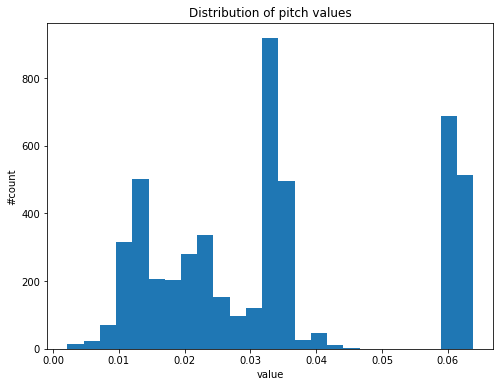

In [24]:
plot_simple_hist(videos_data.pitch, "Distribution of pitch values", "value", "#count")

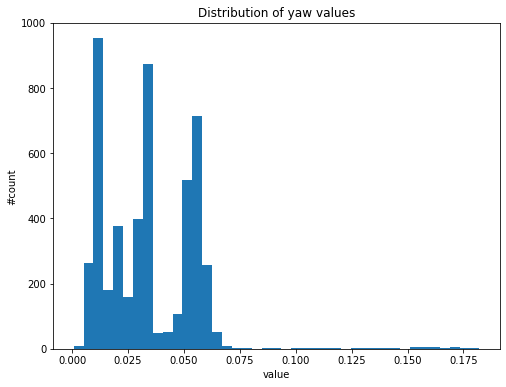

In [25]:
plot_simple_hist(videos_data.yaw, "Distribution of yaw values", "value", "#count")

### 2.3. Visualizations.

Visualizations can deepen our understanding of the data. Since we are dealing with video, hence time too, it is a good idea to explore how the targets change overtime.

In [26]:
def universal_plot(x, y, title, xlabel, ylabel, size=(15, 5), label=None):
    plt.figure(figsize=size)
    plt.plot(x, y, label=label)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    if label:
        plt.legend()
    
    plt.show()

In [27]:
def plot_target_by_cat(df, col, cat, title, xlabel, ylabel):
    for vid_id, vid_data in df.groupby(cat):
        universal_plot(vid_data.frame_number, vid_data[col], f"{title} {vid_id}", xlabel, ylabel)

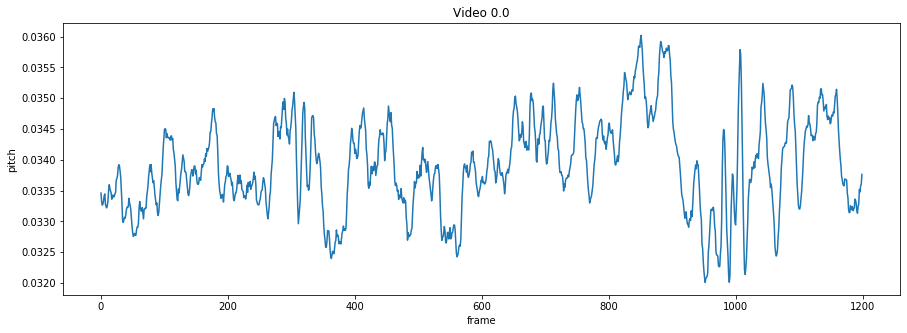

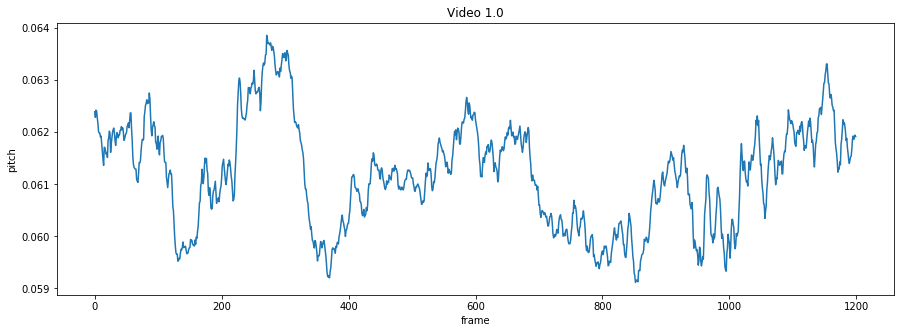

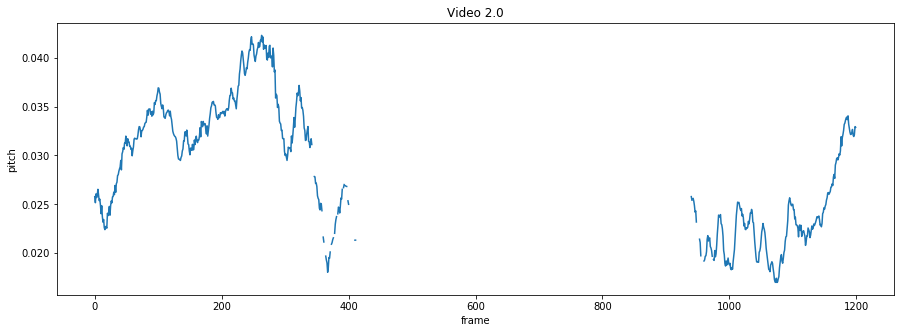

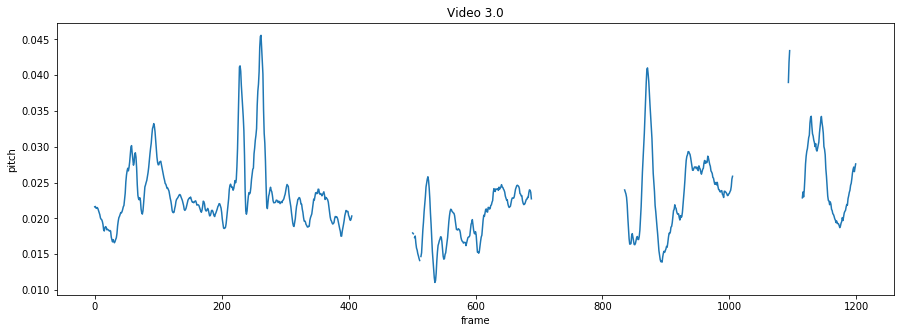

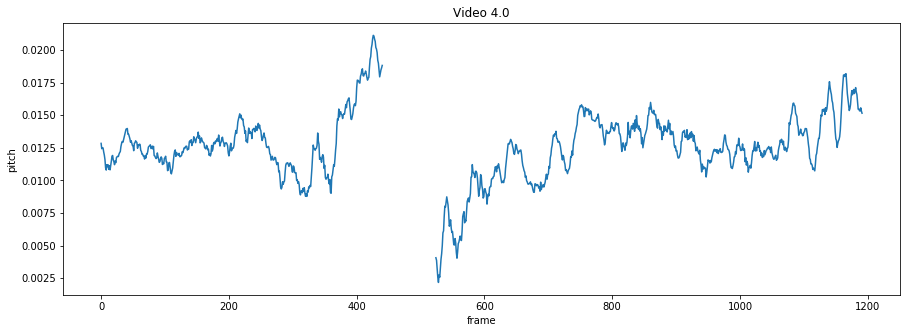

In [28]:
plot_target_by_cat(videos_data, "pitch", "video_id", "Video", "frame", "pitch")

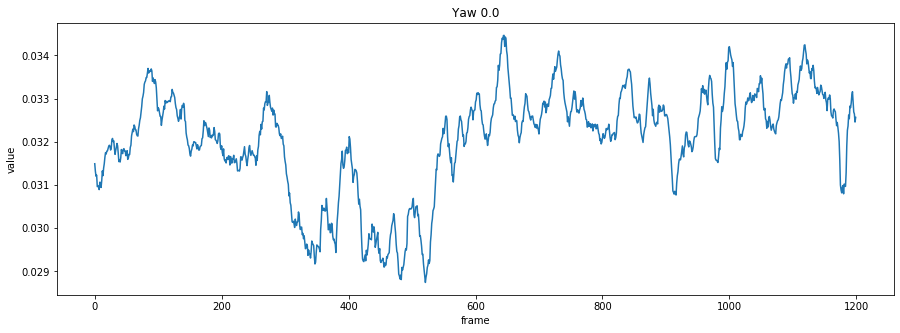

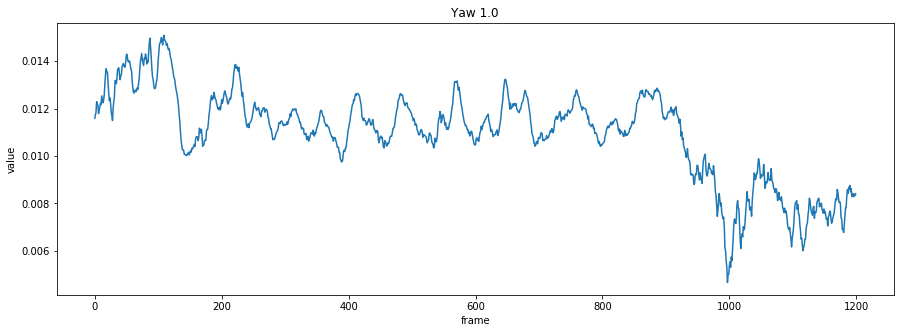

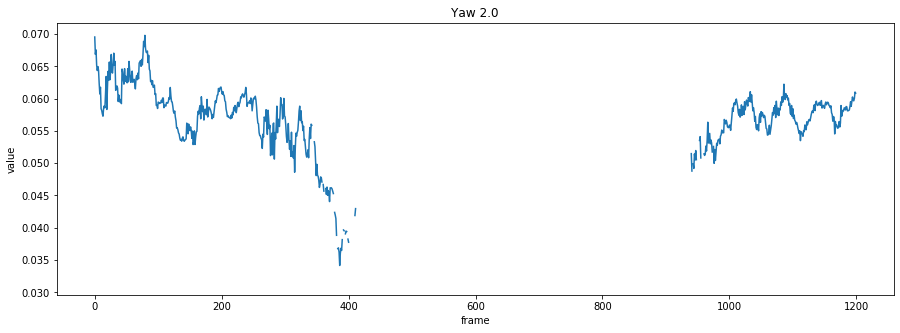

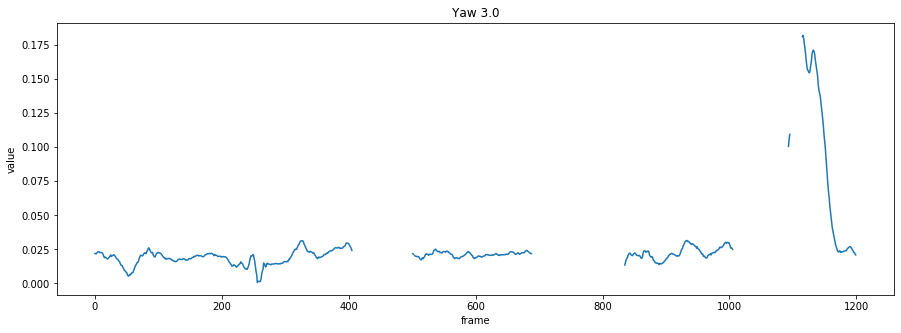

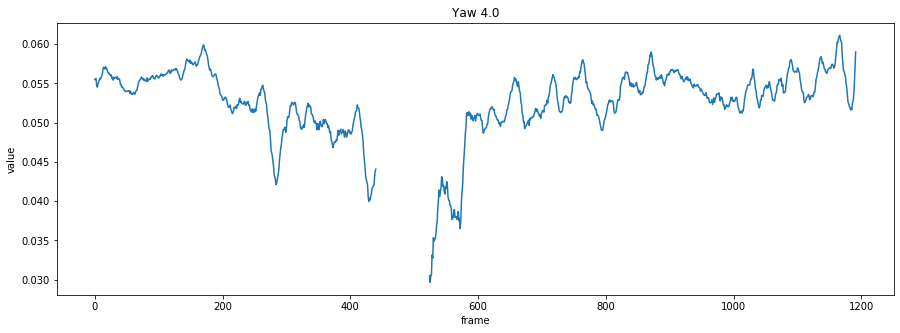

In [29]:
plot_target_by_cat(videos_data, "yaw", "video_id", "Yaw", "frame", "value")

These plots seem very sporadic and the y ranges are tiny. 
What do these peaks and troughs mean? In video number 1, there is a huge dip in the pitch from frames 300 to 400 roughly. Does something distinct happen in the video during that time?

A small function will get only the part of the data we are interested in, and cv2 will take care of making the clip. I am not aware of an easy way of showing videos in jupyter notebook, so some manual work is needed. I convert the .avi videos to gifs online (https://ezgif.com/video-to-gif) and the host them in imgur. Only than can I display them easily within a markdown cell.

In [30]:
def inspect_data_piece(df, video_id, target, feat_range=(0, 100), return_piece=False):
    left_b, right_b = feat_range
    
    video_data = df[df.video_id == video_id]
    piece_data = video_data.iloc[left_b:right_b]

    universal_plot(piece_data.frame_number, piece_data[target], f"Video {video_id}", "frame", target)
    
    if return_piece:
        return piece_data

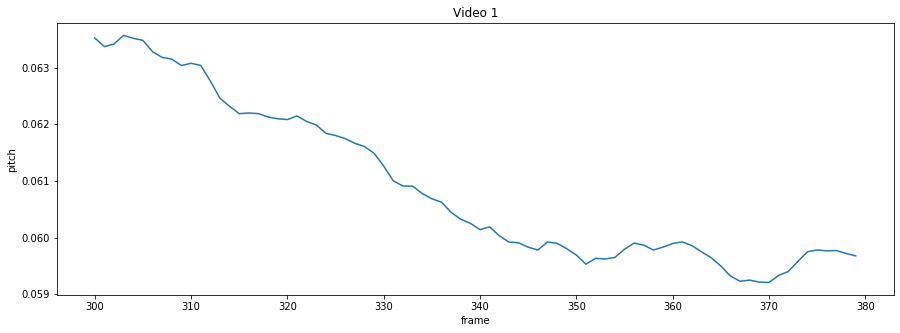

In [31]:
pitch_dip_vid_1 = inspect_data_piece(videos_data, 1, "pitch", (300, 380), return_piece=True)

In [32]:
def make_video_from_piece(data, name, folder=""):
    """
    Make a movie from data.
    """
    img_array = []
    
    for path in data.path:
        img = cv2.imread(path)
        img_array.append(img)
        
    height, width, layers = img_array[0].shape
    size = (width,height)
    
    out = cv2.VideoWriter(f"{folder}{name}.avi",cv2.VideoWriter_fourcc(*'DIVX'), 15, size)
    
    for i in range(len(img_array)):
        out.write(img_array[i])
        
    out.release()

In [33]:
make_video_from_piece(pitch_dip_vid_1, "pitch_dip_vid_1", folder="interesting-clips/")

![pitch_dip_vid_1](https://imgur.com/aKkfhgH.gif)

Huuuuh? Nothing interesting seems to be happening... Maybe the road is inclined? This is going to be hard for a model. 

There are two sharp peaks in video 3 between frames 200 and 300.

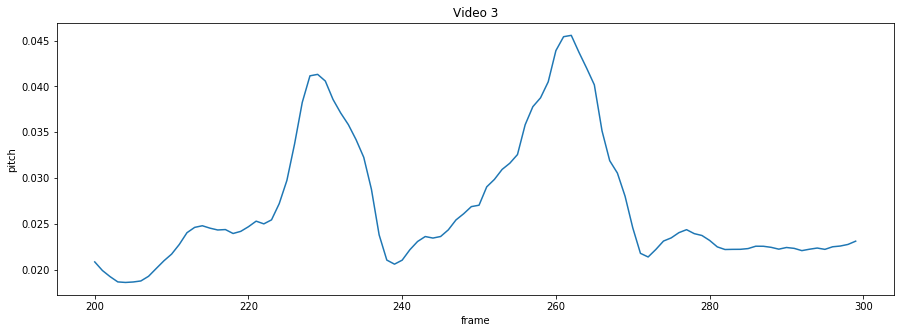

In [34]:
pitch_peaks_vid_3 = inspect_data_piece(videos_data, 3, "pitch", (200, 300), return_piece=True)

In [35]:
make_video_from_piece(pitch_peaks_vid_3, "pitch_peaks_vid_3", folder="interesting-clips/")

![pitch_peaks_vid_3](https://imgur.com/kHIjTYT.gif)

Aha! Road bumps. Now this is a lot more noticeable.

What about the last 100 frames from the 3rd video. Yaw drops drastically in a short period of time.

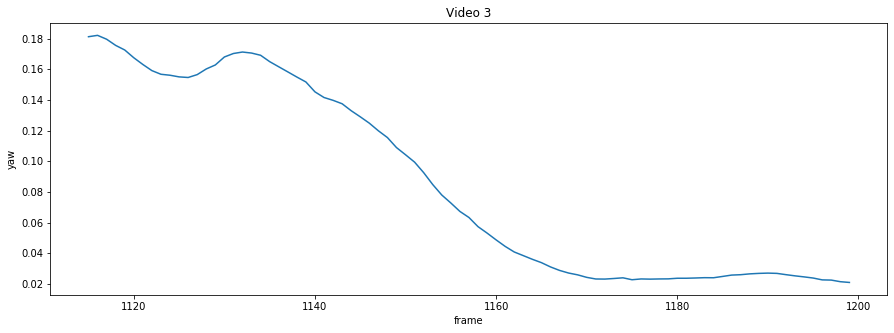

In [36]:
yaw_dip_vid_3 = inspect_data_piece(videos_data, 3, "yaw", (1100, 1200), return_piece=True)

In [37]:
make_video_from_piece(yaw_dip_vid_3, "yaw_dip_vid_3", folder="interesting-clips/")

![yaw_dip_vid_3](https://imgur.com/Puk7ovU.gif)

Changes in **yaw** are obvious - **turning**.

## 3. Data wrangling.

### 3.1. Dropping NANs
The missing labels can be very difficult to impute, because they are related to the video frames. I hope the sudden cunts in the frame sequence will not throw off the model too much.

In [38]:
total_frames_old = videos_data.shape[0]
videos_data = videos_data.dropna()
total_frames = videos_data.shape[0] 
print(f"Original frame count: {total_frames_old}\nCurrent frame count: {total_frames}, {((1 - total_frames / total_frames_old)*100):.2f}% less")

Original frame count: 5996
Current frame count: 5019, 16.29% less


In [39]:
videos_data

video_id  frame_number                                         path  \
0          0.0           0.0     ./data/video_frames_labeled\0\frame0.jpg   
1          0.0           1.0     ./data/video_frames_labeled\0\frame1.jpg   
2          0.0           2.0     ./data/video_frames_labeled\0\frame2.jpg   
3          0.0           3.0     ./data/video_frames_labeled\0\frame3.jpg   
4          0.0           4.0     ./data/video_frames_labeled\0\frame4.jpg   
...        ...           ...                                          ...   
5987       4.0        1187.0  ./data/video_frames_labeled\4\frame1187.jpg   
5988       4.0        1188.0  ./data/video_frames_labeled\4\frame1188.jpg   
5989       4.0        1189.0  ./data/video_frames_labeled\4\frame1189.jpg   
5990       4.0        1190.0  ./data/video_frames_labeled\4\frame1190.jpg   
5991       4.0        1191.0  ./data/video_frames_labeled\4\frame1191.jpg   

         pitch       yaw  
0     0.033461  0.031492  
1     0.033320  0.031317  
2     0.033264  0.031203  
3     0.033280  0.031227  
4     0.033334  0.030963  
...        ...       ...  
5987  0.015339  0.052701  
5988  0.015328  0.053488  
5989  0.015568  0.055036  
5990  0.015318  0.057053  
5991  0.015155  0.058989  

[5019 rows x 5 columns]

In [40]:
videos_data = videos_data.reset_index()

## 4. Splitting the data.

### 4.1. Test data.

Frames in each one video are very similar to each other (ex. driving on a highway has mostly the same scenery), if the model over-fits the train set, it can falsely report great performance even on the test set, since they are very much alike.

To remedy this problem the entire last video will be the test set. This ensure more realistic results.

In [41]:
train_val_df = videos_data[videos_data.video_id != 4]
test_df = videos_data[videos_data.video_id == 4]

### 4.2. Validation data. 

The last 10% of each video might be sufficient for a representative validation set. As laid out in **4.1.** this might be a bad idea, since the train and val set might be too much the same.

In [42]:
def split(df, group, percent_val_per_video=0.1):
    norm_metadata = dict()
    train = pd.DataFrame()
    val = pd.DataFrame()
    
    for i, data in df.groupby(group):
        splitting_point = int(len(data)*(1 - percent_val_per_video))
            
        train = train.append(data.iloc[:splitting_point])
        val = val.append(data.iloc[splitting_point:])
        
    return train, val

In [43]:
group = "video_id"

In [44]:
train_df, val_df = split(train_val_df, group)

### 4.3. Targets scaling.

Usually, scaling the targets is not aways the best idea. In this case Tsetso from the future says that scaling the **targets** stabilized the model performance. A standard min max scaler will be applied to the targets.

In [45]:
def min_max_scaler(df, to_scale, group):
    """
    Min max scaler. Scales inputs between 0, 1.
    """
    norm_data = pd.DataFrame()
    norm_metadata = dict()
    
    for i, data in df.groupby(group):
    
        group_min = data[to_scale].min()
        group_max = data[to_scale].max()
    
        norm_metadata[i] = [group_min, group_max]
    
        norm_data = norm_data.append((data[to_scale] - group_min) / (group_max - group_min))
        
    df[to_scale] = norm_data
    
    return df, norm_metadata

In [46]:
targets = ["pitch", "yaw"]

In [47]:
train_scaled_df, train_meta = min_max_scaler(train_df, targets, group)
val_scaled_df, val_meta = min_max_scaler(val_df, targets, group)
test_scaled_df, test_meta = min_max_scaler(test_df, targets, group)

C:\Users\Tsets0\anaconda3\envs\tf2\lib\site-packages\pandas\core\frame.py:3494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


Sanity check that the scaling is alright.

In [48]:
def check_proper_scaling(data, targets):
    for i in data.video_id.unique():
        assert np.array_equal(data[targets][data.video_id == i].max().values, np.array([1., 1.]))
        assert np.array_equal(data[targets][data.video_id == i].min().values, np.array([0., 0.]))

In [49]:
check_proper_scaling(train_scaled_df, targets=targets)
check_proper_scaling(val_scaled_df, targets=targets)
check_proper_scaling(test_scaled_df, targets=targets)

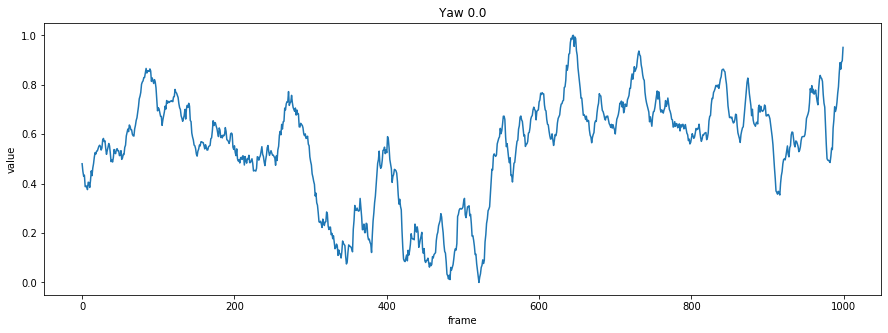

In [50]:
plot_target_by_cat(train_scaled_df.head(1000), "yaw", "video_id", "Yaw", "frame", "value")

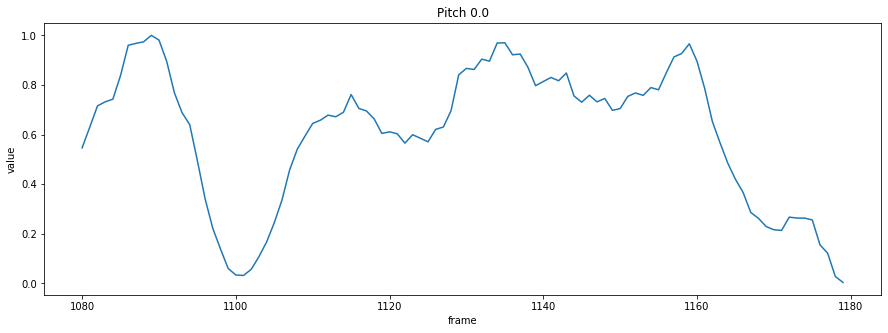

In [51]:
plot_target_by_cat(val_scaled_df.head(100), "pitch", "video_id", "Pitch", "frame", "value")

## 6. Neural networks.

### 6.0. Image preprocessing.

The first few models will be fed individual frames. Standard preprocessing follows.

In [52]:
# I tried doing float64 predictions... it failed

# tf.keras.backend.set_floatx("float64")

In [53]:
def process_data(df, img_trans_func):
    features = df.path.values
    targets = df[["pitch", "yaw"]].values
    sub_data = tf.data.Dataset.from_tensor_slices((features, targets))
    sub_data = sub_data.map(img_trans_func)
    return sub_data

In [54]:
def read_img(path, targets):
    file = tf.io.read_file(path)
    img = tf.image.decode_jpeg(file, channels = 3)
    img = tf.image.resize(img, IMG_SIZE)
    img = img / 255.0
    return (img, targets)

In [55]:
train_set = process_data(train_scaled_df, read_img)
val_set = process_data(val_scaled_df, read_img)
test_set = process_data(test_scaled_df, read_img)

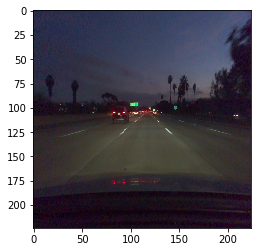

In [99]:
for x, y in train_set:
    plt.imshow(x)
    break

### 6.1. Convolutional models.

#### 6.1.1. Baseline conv model.

Having something to compare later more complex model to will help us put things into perspective. The more complex networks should not be worse than this one.

The models in this section will run on batches of images with shape `[batch_size, width, height, channels]`, for now there is no `time` dimension.

In [56]:
INPUT_DIMS = (224, 224, 3)
batch_size = 64

The architecture is very simple, almost self-explanatory. The slightly interesting part is that this model does **regression**, hence no activation function in the last layer. Interestingly enough, this small model has a lot of trainable parameters. The source of nonlinearity will be the "**relu**" activation function.

In [57]:
baseline_conv_model = Sequential([
    Input(INPUT_DIMS),
    Conv2D(4, (3, 3), activation="relu"),
    Conv2D(8, (3, 3), activation="relu"),
    Flatten(),
    Dense(8, activation="relu"),
    Dense(2, activation=None)
])

In [58]:
baseline_conv_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 4)       112       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 220, 220, 8)       296       
_________________________________________________________________
flatten (Flatten)            (None, 387200)            0         
_________________________________________________________________
dense (Dense)                (None, 8)                 3097608   
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 18        
Total params: 3,098,034
Trainable params: 3,098,034
Non-trainable params: 0
_________________________________________________________________


I will use "**Adam**" as an optimizer in every task, it is robust and fast. The most suitable loss function is mean squared error.

In [59]:
baseline_conv_model.compile(optimizer=Adam(), loss="mse", metrics=['mae'])

In [60]:
baseline_conv_model_history = baseline_conv_model.fit(
    train_set.batch(batch_size),
    validation_data=val_set.batch(batch_size),
    epochs=10,
    callbacks=[tf.keras.callbacks.TensorBoard(log_dir='logs\logs_bcm')])

Train for 55 steps, validate for 7 steps
Epoch 1/10
55/55 [==============================] - 27s 494ms/step - loss: 1.4446 - mae: 0.6185 - val_loss: 0.2860 - val_mae: 0.4852
Epoch 2/10
55/55 [==============================] - 16s 289ms/step - loss: 0.2545 - mae: 0.4478 - val_loss: 0.2646 - val_mae: 0.4632
Epoch 3/10
55/55 [==============================] - 16s 289ms/step - loss: 0.2314 - mae: 0.4216 - val_loss: 0.2416 - val_mae: 0.4403
Epoch 4/10
55/55 [==============================] - 16s 290ms/step - loss: 0.2077 - mae: 0.3934 - val_loss: 0.2192 - val_mae: 0.4180
Epoch 5/10
55/55 [==============================] - 16s 289ms/step - loss: 0.1850 - mae: 0.3653 - val_loss: 0.1983 - val_mae: 0.3966
Epoch 6/10
55/55 [==============================] - 16s 289ms/step - loss: 0.1642 - mae: 0.3389 - val_loss: 0.1795 - val_mae: 0.3769
Epoch 7/10
55/55 [==============================] - 16s 288ms/step - loss: 0.1456 - mae: 0.3155 - val_loss: 0.1630 - val_mae: 0.3589
Epoch 8/10
55/55 [==========

The numbers that tensorflow shows when training are really useful, but it is more pleasant to see them on a plot.

In [61]:
def simple_plot(ground, pred, xlabel, ylabel, title):
    plt.figure(figsize=(15, 5))
    plt.plot(ground, label = "ground")
    plt.plot(pred, label = "pred")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

In [62]:
def visualise_preds(model, data, xlabel, ylabels, title):
    ylabel1, ylabel2 = ylabels 
    
    preds = model.predict(data.batch(batch_size))
    y = [x[1] for x in data]

    pitch_y = [x[0] for x in y]
    yaw_y = [x[1] for x in y]

    pitch_pred = [x[0] for x in preds]
    yaw_pred = [x[1] for x in preds]
    
    simple_plot(pitch_y, pitch_pred, xlabel, ylabel1, title)
    simple_plot(yaw_y, yaw_pred, xlabel, ylabel2, title)

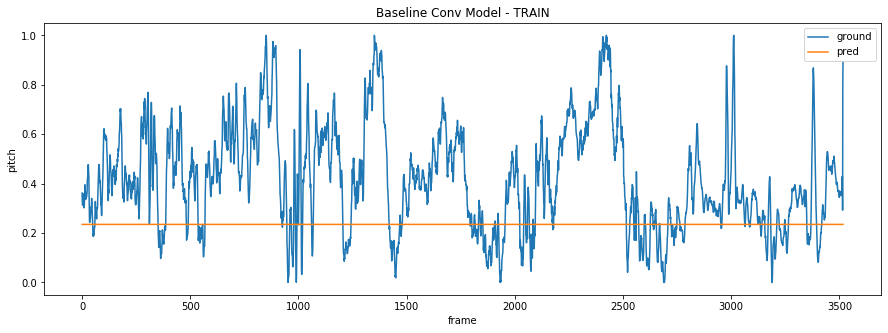

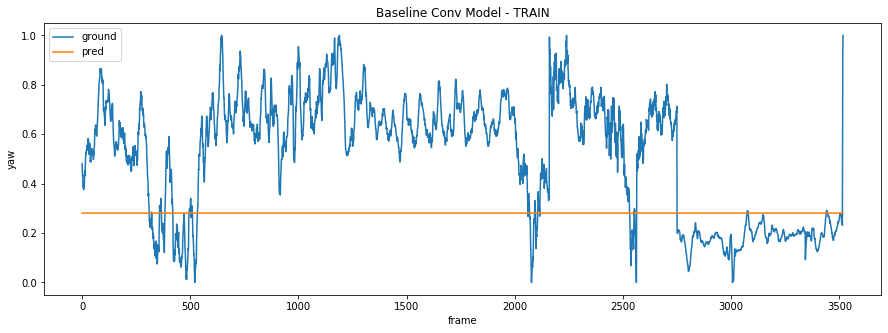

In [63]:
visualise_preds(baseline_conv_model, train_set, "frame", targets, "Baseline Conv Model - TRAIN")

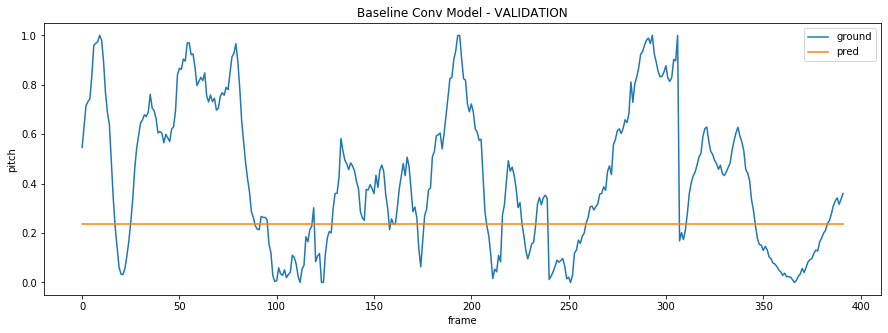

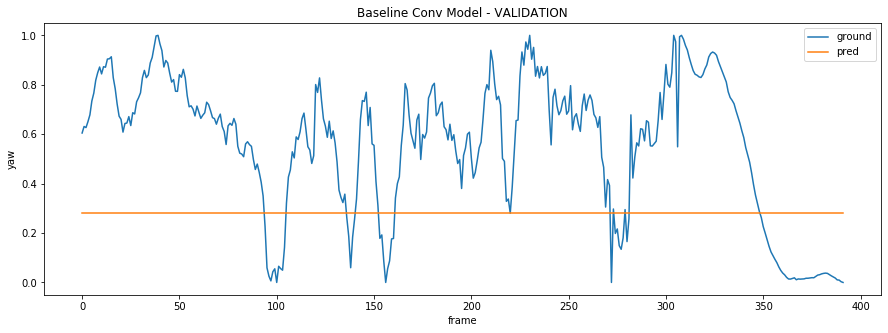

In [64]:
visualise_preds(baseline_conv_model, val_set, "frame", targets, "Baseline Conv Model - VALIDATION")

In [65]:
def plot_res(history, title):
    
    plt.figure(figsize=(10, 6))
    plt.plot(history.history["loss"], label="train")
    plt.plot(history.history["val_loss"], label="val")
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

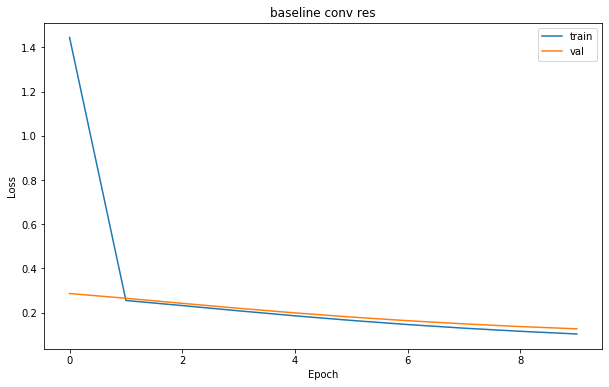

In [66]:
plot_res(baseline_conv_model_history, "baseline conv res")

Here comes the really **weird** part. In an earlier notebook, this exact model performed seemingly godly, but it is trash. The comments were written to the "godly" model. Fortunately I saved it, and will load it, so that the comments make sense. How is this possible? Did I win the optimization lottery?

In [67]:
godly_baseline_model = tf.keras.models.load_model("saved_models\godly_baseline_model.h5")

In [73]:
godly_baseline_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 222, 222, 4)       112       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 220, 220, 8)       296       
_________________________________________________________________
flatten_2 (Flatten)          (None, 387200)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 3097608   
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 18        
Total params: 3,098,034
Trainable params: 3,098,034
Non-trainable params: 0
_________________________________________________________________


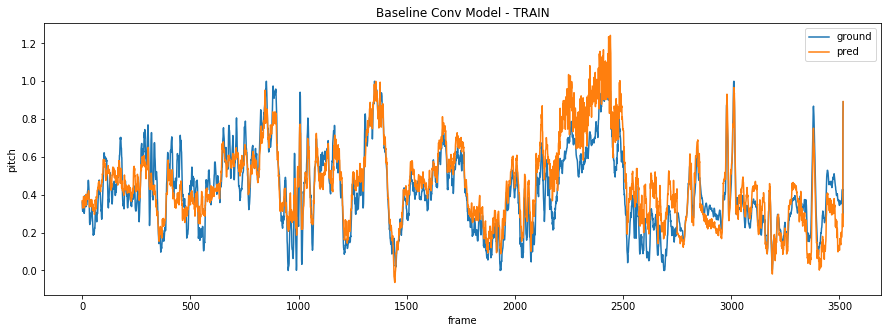

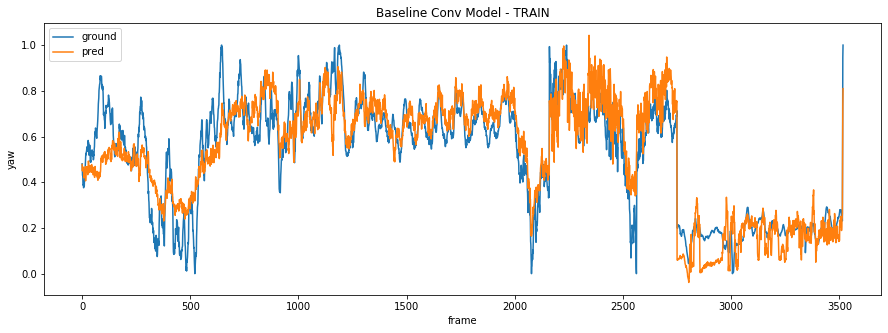

In [68]:
visualise_preds(godly_baseline_model, train_set, "frame", targets, "Godly baseline Conv Model - TRAIN")

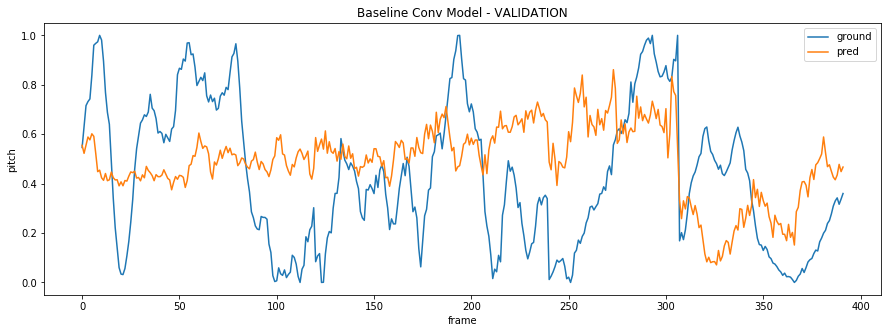

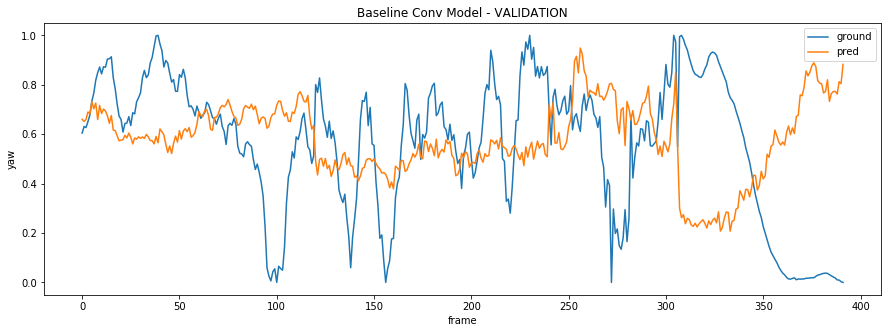

In [69]:
visualise_preds(godly_baseline_model, val_set, "frame", targets, "Godly baseline Conv Model - VALIDATION")

Veeery surprising. The **baseline** model already does quite well. There is some obvious over-fitting issues. Is this a case of the validation set being too alike with the train set? Let's validate on the test set.

In [70]:
godly_baseline_model.evaluate(test_set.batch(batch_size))

18/18 [==============================] - 8s 426ms/step - loss: 0.0647 - mae: 0.2013


[0.06468670132259528, 0.20134188]

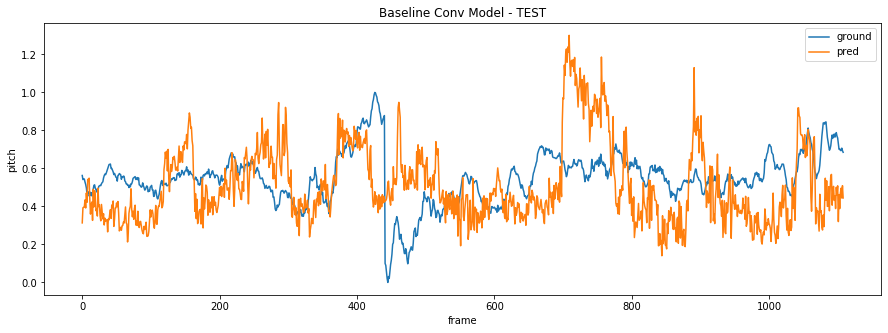

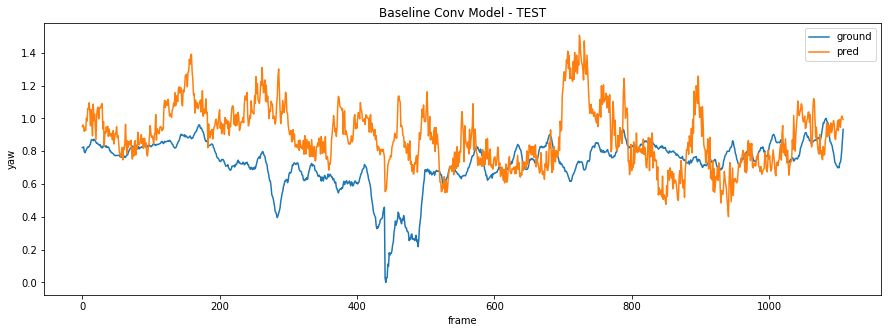

In [71]:
visualise_preds(godly_baseline_model, test_set, "frame", targets, "Godly baseline Conv Model - TEST")

In [72]:
# baseline_conv_model.save("baseline_conv_model_awesome.h5")

Wow, not too shabby at all.

#### 6.1.2. Simple conv model.
Let's try something with more capacity. More conv layers open up opportunities for better learning. Everything else stays the same.

In [74]:
tf.keras.backend.clear_session()

In [75]:
simple_conv_model = Sequential([
    Input(INPUT_DIMS),
    Conv2D(8, (3, 3), activation="relu"),
    Conv2D(16, (3, 3), activation="relu"),
    Conv2D(32, (3, 3), activation="relu"),
    Flatten(),
    Dense(8, activation="relu"),
    Dense(2, activation=None)
])

In [76]:
simple_conv_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 8)       224       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 220, 220, 16)      1168      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 218, 218, 32)      4640      
_________________________________________________________________
flatten (Flatten)            (None, 1520768)           0         
_________________________________________________________________
dense (Dense)                (None, 8)                 12166152  
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 18        
Total params: 12,172,202
Trainable params: 12,172,202
Non-trainable params: 0
____________________________________________

In [77]:
simple_conv_model.compile(optimizer=Adam(), loss="mse", metrics=['mae'])

In [78]:
simple_conv_model_history = simple_conv_model.fit(
    train_set.batch(batch_size),
    validation_data=val_set.batch(batch_size),
    epochs=10,
    callbacks=[tf.keras.callbacks.TensorBoard(log_dir='logs\logs_scm')])

Train for 55 steps, validate for 7 steps
Epoch 1/10
55/55 [==============================] - 17s 307ms/step - loss: 20.2452 - mae: 1.1417 - val_loss: 0.2963 - val_mae: 0.4961
Epoch 2/10
55/55 [==============================] - 16s 290ms/step - loss: 0.2717 - mae: 0.4671 - val_loss: 0.2897 - val_mae: 0.4889
Epoch 3/10
55/55 [==============================] - 16s 291ms/step - loss: 0.2641 - mae: 0.4587 - val_loss: 0.2814 - val_mae: 0.4799
Epoch 4/10
55/55 [==============================] - 16s 293ms/step - loss: 0.2550 - mae: 0.4486 - val_loss: 0.2720 - val_mae: 0.4699
Epoch 5/10
55/55 [==============================] - 16s 290ms/step - loss: 0.2448 - mae: 0.4371 - val_loss: 0.2618 - val_mae: 0.4594
Epoch 6/10
55/55 [==============================] - 16s 289ms/step - loss: 0.2340 - mae: 0.4245 - val_loss: 0.2511 - val_mae: 0.4486
Epoch 7/10
55/55 [==============================] - 16s 289ms/step - loss: 0.2228 - mae: 0.4113 - val_loss: 0.2401 - val_mae: 0.4377
Epoch 8/10
55/55 [=========

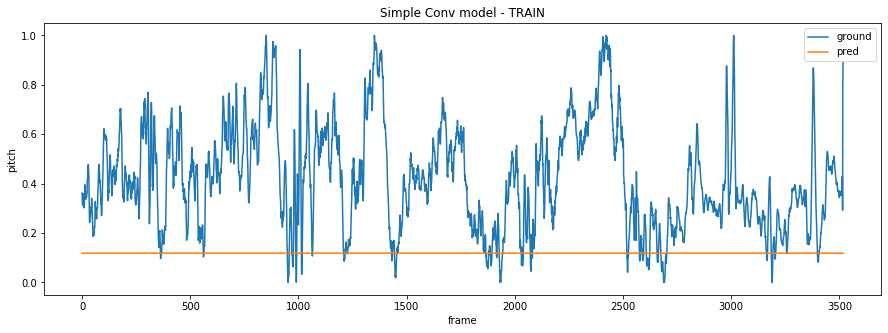

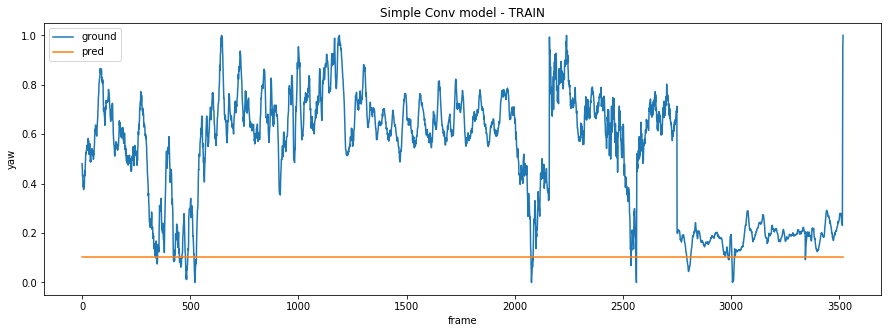

In [79]:
visualise_preds(simple_conv_model, train_set, "frame", targets, "Simple Conv model - TRAIN")

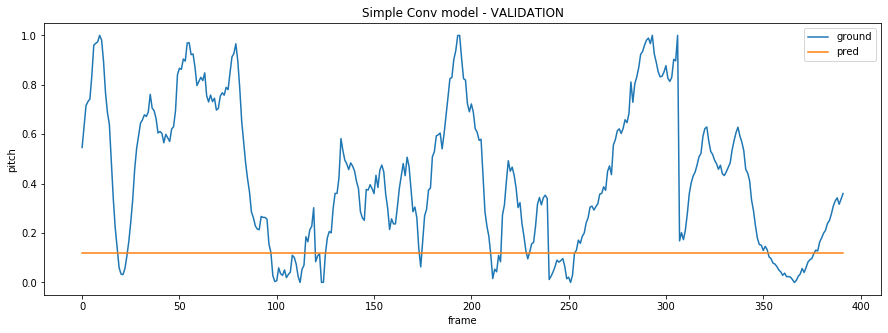

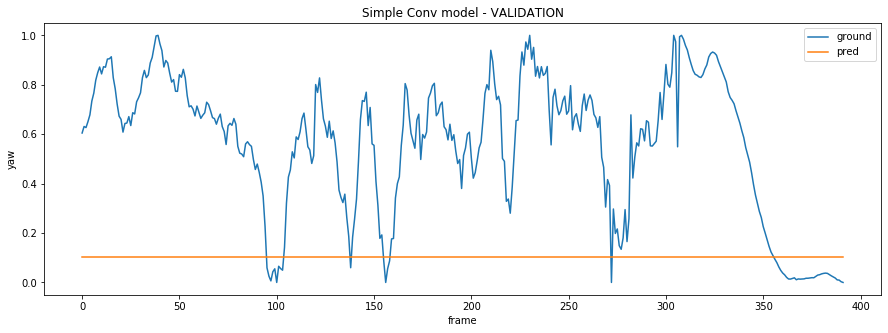

In [80]:
visualise_preds(simple_conv_model, val_set, "frame", targets, "Simple Conv model - VALIDATION")

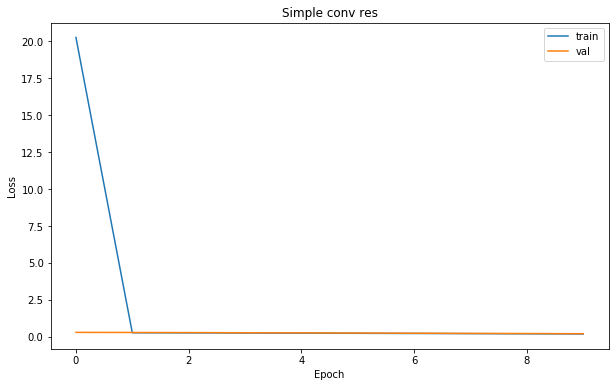

In [81]:
plot_res(simple_conv_model_history, "Simple conv res")

Huh? The more complicated model does **worse** than the baseline? Why does this model just learn some mean of the data? Is the optimizer overshooting the minimum? Is the model really too complicated for the data?

#### 6.1.3. Simple conv model - search.

The model above does very poorly, but it is more complex than the baseline. At this point I thought that the model might be overshooting the local minimums, and goes to a huge, but shallow minimum where it just learns the mean of the data. I lowered the learning rate, but to no avail.

Maybe the decoder is too simple for the encoder, so I buffed that up. The results where still much worse than the baseline.

I went back to a model very similar to the baseline, and buffed the encoder part a bit - no change. I buffed the decoder part - no change. I was very confused.

I even tried the exact same model as the baseline and got miserable results. How? Maybe the first model just had lucky initial values. So I tried "he_normal" as the kernel initializer and still no change. Buffing the decoder on this model gave a significant change.

Adding more simple conv layers gave nice results, I chose to keep this particular model.

More importantly, I tried regularizing the other models that were over-fitting with max pooling, and dropout and even batch normalization, but with too much of it the model would start spitting out some constant mean value.

In [91]:
tf.keras.backend.clear_session()

In [92]:
simple_conv_model = Sequential([
    Input(INPUT_DIMS),
    Conv2D(2, (3, 3), activation="relu"),
    Conv2D(2, (3, 3), activation="relu"),
    Conv2D(4, (3, 3), activation="relu"),
    Conv2D(4, (3, 3), activation="relu"),
    Flatten(),
    Dense(16, activation="relu"),
    Dense(2, activation=None)
])

In [93]:
simple_conv_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 2)       56        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 220, 220, 2)       38        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 218, 218, 4)       76        
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 216, 216, 4)       148       
_________________________________________________________________
flatten (Flatten)            (None, 186624)            0         
_________________________________________________________________
dense (Dense)                (None, 16)                2986000   
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 3

In [94]:
simple_conv_model.compile(optimizer=Adam(), loss="mse", metrics=["mae"])

In [95]:
simple_conv_model_history = simple_conv_model.fit(
    train_set.batch(batch_size),
    validation_data=val_set.batch(batch_size),
    epochs=10,
    callbacks=[
        tf.keras.callbacks.TensorBoard(log_dir='logs\logs_scm')
    ])

Train for 55 steps, validate for 7 steps
Epoch 1/10
55/55 [==============================] - 17s 302ms/step - loss: 0.0877 - mae: 0.2411 - val_loss: 0.2392 - val_mae: 0.4392
Epoch 2/10
55/55 [==============================] - 16s 288ms/step - loss: 0.1287 - mae: 0.2933 - val_loss: 0.1670 - val_mae: 0.3614
Epoch 3/10
55/55 [==============================] - 16s 288ms/step - loss: 0.0762 - mae: 0.2223 - val_loss: 0.2407 - val_mae: 0.4389
Epoch 4/10
55/55 [==============================] - 16s 289ms/step - loss: 0.1992 - mae: 0.3804 - val_loss: 0.1990 - val_mae: 0.3971
Epoch 5/10
55/55 [==============================] - 16s 290ms/step - loss: 0.1584 - mae: 0.3293 - val_loss: 0.1668 - val_mae: 0.3632
Epoch 6/10
55/55 [==============================] - 16s 289ms/step - loss: 0.1293 - mae: 0.2944 - val_loss: 0.1440 - val_mae: 0.3381
Epoch 7/10
55/55 [==============================] - 16s 289ms/step - loss: 0.1082 - mae: 0.2704 - val_loss: 0.1274 - val_mae: 0.3185
Epoch 8/10
55/55 [==========

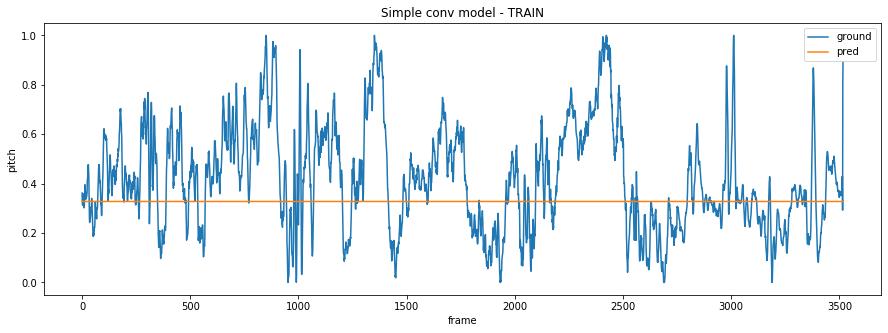

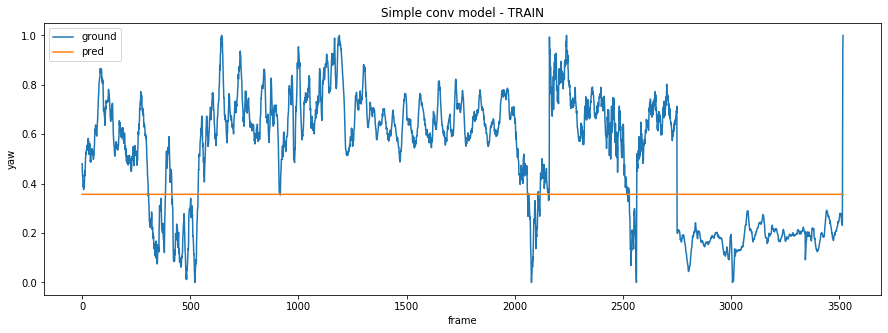

In [96]:
visualise_preds(simple_conv_model, train_set, "frame", targets, "Simple conv model - TRAIN")

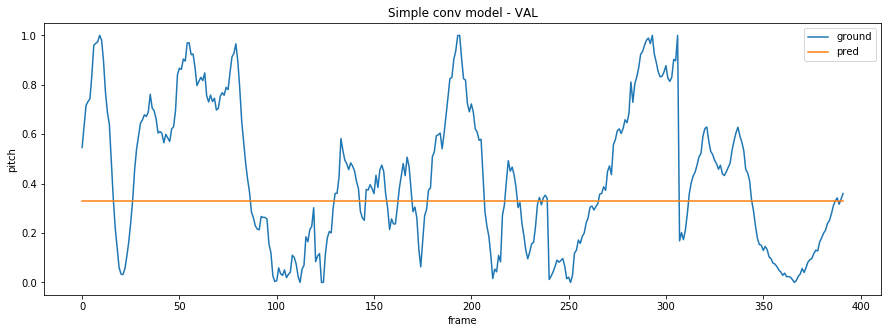

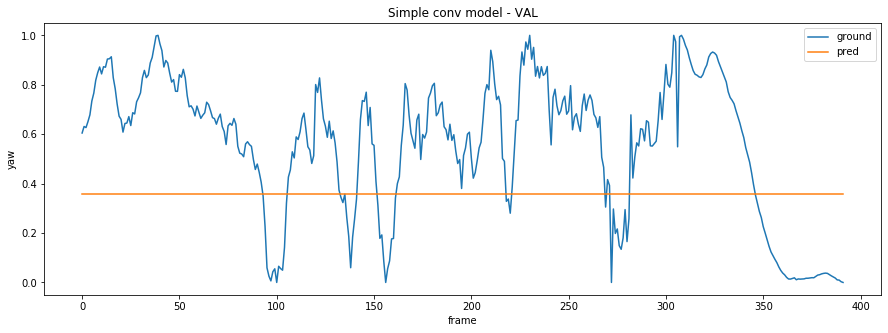

In [97]:
visualise_preds(simple_conv_model, val_set, "frame", targets, "Simple conv model - VAL")

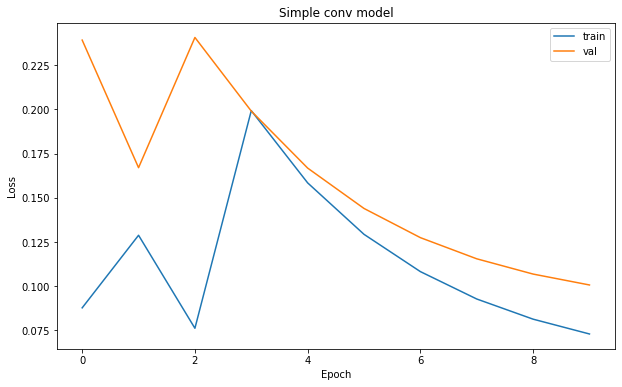

In [98]:
plot_res(simple_conv_model_history, "Simple conv model")

Results are abominable... I cannot decide whether the model is too weak or strong.

#### 6.1.4. Transfer learning with ResNet50V2.

Transfer learning is a powerful tool. Pre-trained models can be used as "universal" encoders, and we attach a decoder of our liking to it. In this case I chose ResNet50V2 for no particular reason, other that residual connections might help with exploding or vanishing gradients, since video frames look very similar.

In [100]:
tf.keras.backend.clear_session()

In [101]:
res_net_50V2 = resnet_v2.ResNet50V2(weights="imagenet", include_top=False)

In [102]:
res_net_50V2.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, None, None, 6 0           conv1_conv[0][0]                 
_________________________________________________________________________________________

Image classification and regression on road data are not too similar, but I decided to not further train the res net. I freeze all the layers and will add a decoder.

In [103]:
for layer in res_net_50V2.layers:
    layer.trainable = False

In [104]:
normal_decoder = Sequential([
    Dense(512, activation="relu"),
    Dense(256, activation="relu"),
    Dropout(0.15),
    Dense(128, activation="relu"),
    Dense(64, activation="relu"),
    Dropout(0.08),
    Dense(2, activation=None),
])

In [105]:
res_net_50V2_transfered_n_deck = Sequential([
    res_net_50V2,
    GlobalAveragePooling2D(),
    normal_decoder
])

In [106]:
res_net_50V2_transfered_n_deck.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, None, None, 2048)  23564800  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
sequential (Sequential)      (None, 2)                 1221698   
Total params: 24,786,498
Trainable params: 1,221,698
Non-trainable params: 23,564,800
_________________________________________________________________


In [107]:
res_net_50V2_transfered_n_deck.compile(optimizer=Adam(), loss = "mse", metrics=["mae"])

The data preprocessing steps are a bit different for this model, luckily that is taken care of with `resnet_v2.preprocess_input()`

In [108]:
def read_img_resnet(path, targets):
    file = tf.io.read_file(path)
    img = tf.image.decode_jpeg(file, channels = 3)
    img = tf.image.resize(img, IMG_SIZE)
    img = resnet_v2.preprocess_input(img)
    return (img, targets)

In [109]:
train_set_resnet = process_data(train_scaled_df, read_img_resnet)
val_set_resnet = process_data(val_scaled_df, read_img_resnet)
test_set_resnet = process_data(test_scaled_df, read_img_resnet)

In [110]:
res_net_50V2_transfered_n_deck_history = res_net_50V2_transfered_n_deck.fit(
    train_set_resnet.batch(batch_size),
    validation_data=(val_set_resnet.batch(batch_size)),
    epochs=10,
    callbacks=[tf.keras.callbacks.TensorBoard(log_dir='logs\logs_rn50tn')])

Train for 55 steps, validate for 7 steps
Epoch 1/10
55/55 [==============================] - 20s 361ms/step - loss: 0.1114 - mae: 0.2545 - val_loss: 0.0921 - val_mae: 0.2706
Epoch 2/10
55/55 [==============================] - 16s 294ms/step - loss: 0.0726 - mae: 0.2146 - val_loss: 0.1303 - val_mae: 0.3220
Epoch 3/10
55/55 [==============================] - 16s 296ms/step - loss: 0.0644 - mae: 0.2005 - val_loss: 0.1283 - val_mae: 0.3218
Epoch 4/10
55/55 [==============================] - 17s 316ms/step - loss: 0.0616 - mae: 0.1969 - val_loss: 0.1361 - val_mae: 0.3303
Epoch 5/10
55/55 [==============================] - 16s 298ms/step - loss: 0.0598 - mae: 0.1930 - val_loss: 0.1355 - val_mae: 0.3295
Epoch 6/10
55/55 [==============================] - 16s 296ms/step - loss: 0.0607 - mae: 0.1928 - val_loss: 0.1266 - val_mae: 0.3192
Epoch 7/10
55/55 [==============================] - 16s 296ms/step - loss: 0.0602 - mae: 0.1912 - val_loss: 0.1331 - val_mae: 0.3266
Epoch 8/10
55/55 [==========

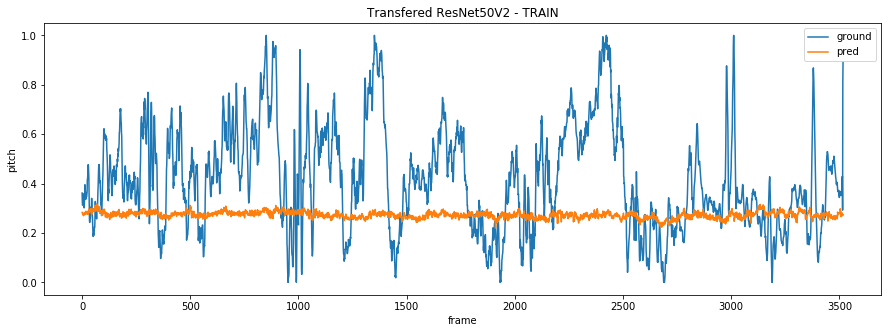

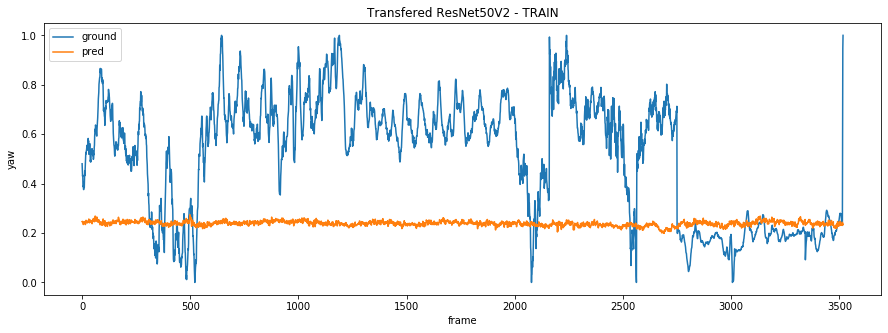

In [111]:
visualise_preds(res_net_50V2_transfered_n_deck, train_set_resnet, "frame", targets, "Transfered ResNet50V2 - TRAIN")

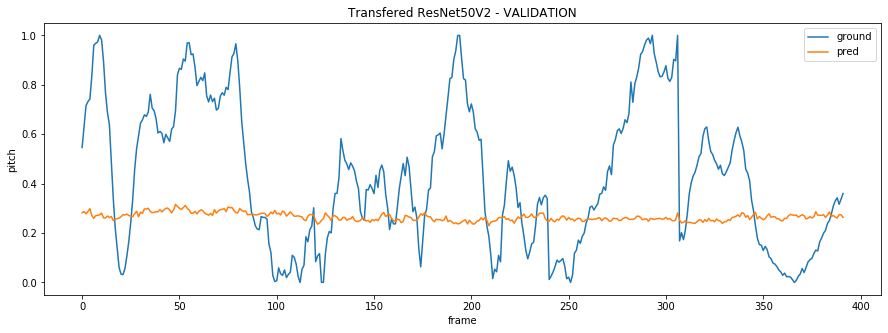

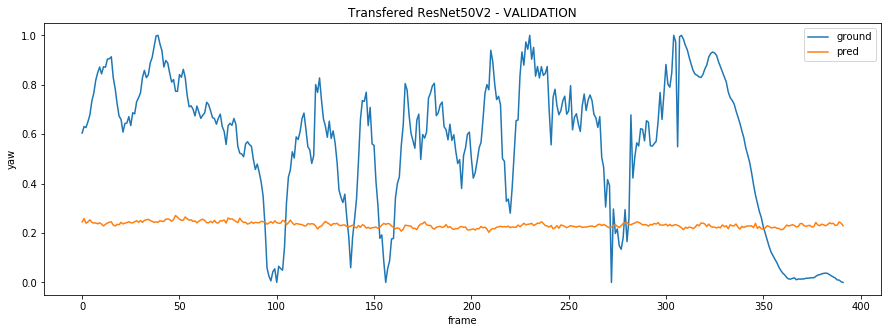

In [112]:
visualise_preds(res_net_50V2_transfered_n_deck, val_set_resnet, "frame", targets, "Transfered ResNet50V2 - VALIDATION")

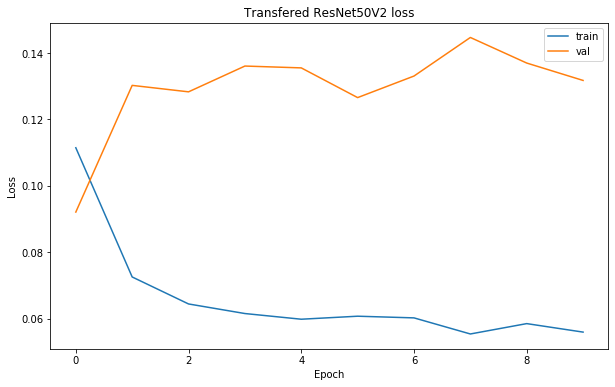

In [113]:
plot_res(res_net_50V2_transfered_n_deck_history, "Transfered ResNet50V2 loss")

Somehow even this model goes straight for some kind of mean values. At this point there might be several reasons:
1. The tasks are too different and some layers need to be further trained.
2. The decoder is too deep and/or wide.

Let's investigate the second reason.

In [114]:
small_decoder = Sequential([
    Dense(128, activation="relu"),
    Dropout(0.1),
    Dense(2, activation=None),
])

In [115]:
res_net_50V2_transfered_s_deck = Sequential([
    res_net_50V2,
    GlobalAveragePooling2D(),
    small_decoder
])

In [116]:
res_net_50V2_transfered_s_deck.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, None, None, 2048)  23564800  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 2)                 262530    
Total params: 23,827,330
Trainable params: 262,530
Non-trainable params: 23,564,800
_________________________________________________________________


In [117]:
res_net_50V2_transfered_s_deck.compile(optimizer=Adam(),
                                       loss="mse",
                                       metrics=["mae"])

In [118]:
res_net_50V2_transfered_s_deck_history = res_net_50V2_transfered_s_deck.fit(
    train_set_resnet.batch(batch_size),
    validation_data=(val_set_resnet.batch(batch_size)),
    epochs=10,
    callbacks=[tf.keras.callbacks.TensorBoard(log_dir='logs\logs_rn50ts')])

Train for 55 steps, validate for 7 steps
Epoch 1/10
55/55 [==============================] - 19s 345ms/step - loss: 0.1840 - mae: 0.2997 - val_loss: 0.3227 - val_mae: 0.4852
Epoch 2/10
55/55 [==============================] - 16s 295ms/step - loss: 0.0764 - mae: 0.2157 - val_loss: 0.1371 - val_mae: 0.2996
Epoch 3/10
55/55 [==============================] - 16s 295ms/step - loss: 0.0743 - mae: 0.2141 - val_loss: 0.1114 - val_mae: 0.2745
Epoch 4/10
55/55 [==============================] - 16s 295ms/step - loss: 0.0739 - mae: 0.2167 - val_loss: 0.1148 - val_mae: 0.2640
Epoch 5/10
55/55 [==============================] - 16s 294ms/step - loss: 0.0686 - mae: 0.2128 - val_loss: 0.1099 - val_mae: 0.2586
Epoch 6/10
55/55 [==============================] - 16s 295ms/step - loss: 0.0664 - mae: 0.2101 - val_loss: 0.1090 - val_mae: 0.2584
Epoch 7/10
55/55 [==============================] - 16s 297ms/step - loss: 0.0639 - mae: 0.2052 - val_loss: 0.1101 - val_mae: 0.2590
Epoch 8/10
55/55 [==========

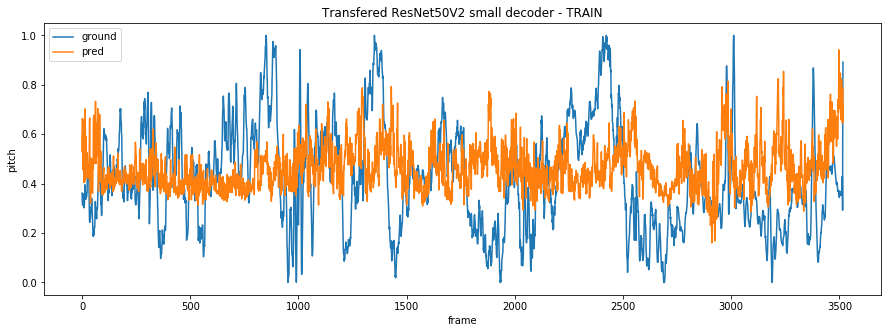

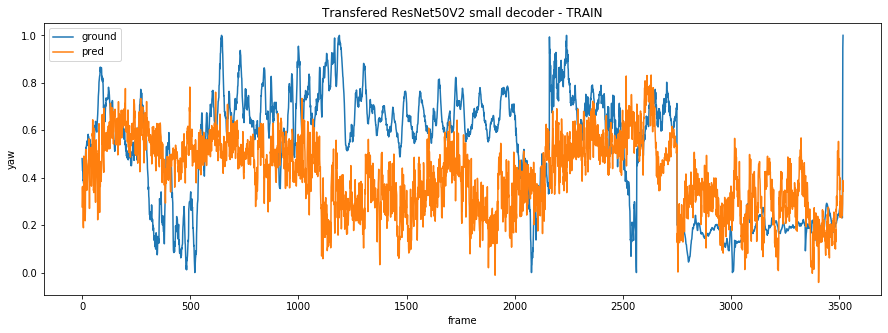

In [119]:
visualise_preds(res_net_50V2_transfered_s_deck, train_set_resnet, "frame", targets, "Transfered ResNet50V2 small decoder - TRAIN")

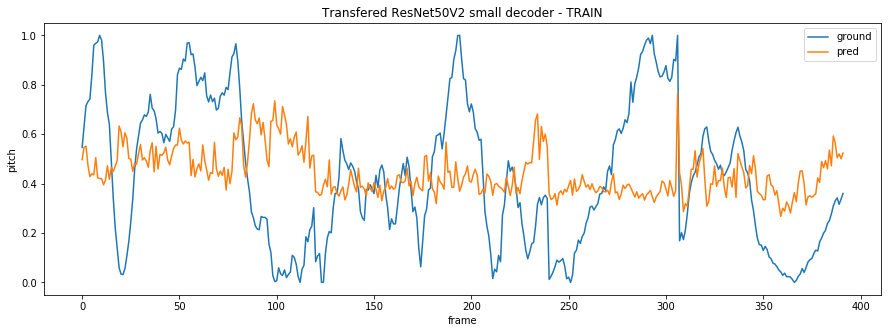

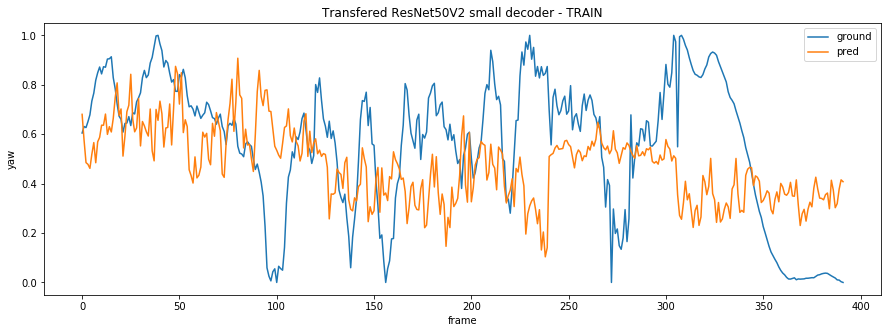

In [120]:
visualise_preds(res_net_50V2_transfered_s_deck, val_set_resnet, "frame", targets, "Transfered ResNet50V2 small decoder - TRAIN")

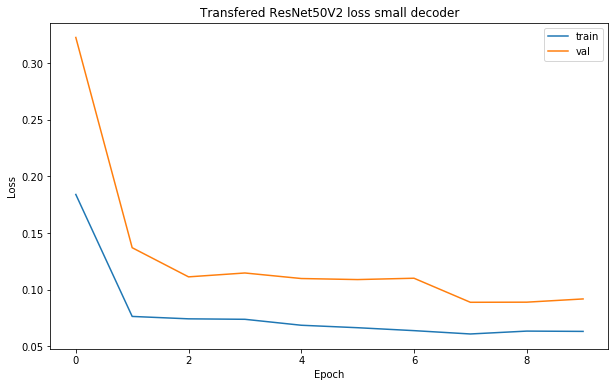

In [121]:
plot_res(res_net_50V2_transfered_s_deck_history, "Transfered ResNet50V2 loss small decoder") 

In [122]:
tf.keras.backend.clear_session()

These might be the limits of models that do **not** take dependencies between frames into account.

### 6.2. Time dimension.

The data shapes for these models was very tricky to get wright. The first problem is that every video has a different length, because we removed the frames with NAN targets. A model requires that the inputs, other than batch_size, stay the same. This is why chopping the videos into smaller clips is the way to go (ex. 8 clips, each with 20 frames). Then taking several clips will form a batch `[batch_size, number_frames, w, h, c]`. `number_frames` will serve as the time dimension.

The video data is not a lot, this is why I decided to up the difficulty a bit and try to generate clips that have some overlap. There is an easy way to do it, using `.TimeSeriesGenerator()`, but then training in a loop, which breaks tensorboard. The proper way to do it is by creating a custom generator class that inherits from `tf.keras.utils.Sequence`. To this point I had no python oop experience, so this was one of the parts, which, not gonna lie, took days.

Let me explain what the `DataGenerator` does. A very smart thing to do (that I did not at first) is to solely work with indexes until the very last moment. Loading the entire train set and then manipulating it is just not feasible.

1. Instead of generating overlapping videos from the start it is much easier to first generate overlapping lists of indexes. This is achieved by the `.make_index_windows` method. Each window has a **length**, the difference between to consecutive elements is **sampling_rate**, and the difference between the starting points of tho lists is the **sequence_stride**. **batch_size** regulates how many lists to group in a single batch.

    Ex. size = 6, sampling_rate = 2, sequence_stride = 5, batch_size = 3.

$$ [ [0, 2, 4, 6, 8, 10], [5, 7, 9, 11, 13, 15], [10, 12, 14, 16, 18, 20] ], ... $$

    These batches are appended to `self.sub_vid_indexes`.

2. For tensorflow to work with this class it is mandatory to implement a `__len__` protocol. It should return the number of batches. At this point it is super useful that we have already generated the windows of indexes and we can treat them as if we had the frames. If we have 15 windows and need 4 per batch, that means we will have $ \left \lceil{\frac{15}{4}}\right \rceil = 4 $ batches, and the last one will have less than the others.

3. The most important part is the `__getitem__` protocol. The generator should return a ready batch when indexed in the range 0 to `self.__len__`. Only at this point are the images read and preprocessed.

This setup sounds simple, and it really is. But when implementing it for the first time, it was insanely hard, and I felt like a genius when I realized that using only the indexes is best.

In [123]:
class DataGenerator(tf.keras.utils.Sequence):
    
    def __init__(self, df, size, sampling_rate = 1, sequence_stride = 1, batch_size = 16, verbose = 0):
        self.df = df
        self.size = size
        self.sampling_rate = sampling_rate
        self.sequence_stride = sequence_stride
        self.batch_size = batch_size
        self.verbose = verbose
        
        # generate the indexes with the desired size, sampling_rate, etc.
        self.sub_vid_indexes = self.make_index_windows(df)
        self.files_count = len(df)
        
        # all df indexes.
        self.indexes = np.arange(self.files_count)
        
    def __len__(self):
        
        return math.ceil(len(self.sub_vid_indexes) / self.batch_size)

    def __getitem__(self, idx):
        labels = []
        images = []
        missing = 0
        
        # The last batch may not always be full.
        # Might just have to remove these.
        if idx == len(self)-1:
            self.print_msg("Last batch is partially full")
            # print(f"Left border: {(idx+1)*self.batch_size}")
            missing = (idx+1)*self.batch_size - len(self.sub_vid_indexes)
            self.print_msg(f"missing {missing} sequences = {missing*self.size} missing frames")

        indexes = self.indexes[idx*self.batch_size:(idx+1)*self.batch_size-missing]
        self.print_msg(f"Batch indexes: {indexes}")
        
        debug_count = 1
        for i in indexes:
            current_sub_vid_indexes = self.sub_vid_indexes[i]
            sub_data = self.df.loc[current_sub_vid_indexes]
            imgs, targets = self.process_data(sub_data)
            labels.append(targets)
            images.append(imgs)
            self.print_msg(f"batch {debug_count}/{self.batch_size} Done.", end="\r")
            debug_count += 1
            
        return np.array(images), np.array(labels)

    def make_index_windows(self, df):
        chopped_vids_indexes = []
        
        for i, video_data in self.df.groupby(["video_id"]):
            # For each video in the df, generate the required
            # indexes, while inside the range of indexes from
            # the original video. If vid 1 is from 1200 to 2300
            # we need to start generating the indexes from 1200
            # and NOT from 0 every time. Return the indexes only,
            # this way it is more memory efficient.
            # The returned list is like [[0, 2, 4], [1, 3, 5], ...,]
            
            first_index = video_data.index.min()
            last_index = video_data.index.max()
            self.print_msg(f"-------------- Video {i}, start: {first_index}, end: {last_index} --------------")
            left_border = first_index
            right_border = first_index
            
            while True:
                right_border = left_border + (self.size * self.sampling_rate)
                
                # If the last remaining elemnts cannot form
                # a full window, skip them, and start with the
                # next video
                if right_border >= last_index:
                    self.print_msg(f"Dropped frames from last seq {right_border-last_index}")
                    break
                
                sub_vid_indexes = np.arange(left_border, right_border, self.sampling_rate)
                # print(sub_vid_indexes)
                chopped_vids_indexes.append(sub_vid_indexes)
                
                left_border += self.sequence_stride
                
        return np.array(chopped_vids_indexes)
    
    def process_data(self, sub_df):
        features = sub_df.path.values
        targets = sub_df[["pitch", "yaw"]].values
        imgs = np.array([self.read_img(path) for path in features])
        return imgs, targets

    def read_img(self, path):
        img = plt.imread(path)
        img = cv2.resize(img, IMG_SIZE)
        img = img / 255.0
        return img
    
    def print_msg(self, msg, end="\n"):
        if self.verbose == 0:
            pass
        elif self.verbose == 1:
            print(msg, end=end)

A small side effect is that some frames are lost when windowing. The last batch can be half full no problem, but each sequence inside the batches need to be the exactly the same length. So if the frames that cannot fit into a full sequence are just not used.

In [124]:
example_gen = DataGenerator(train_scaled_df, 20, 2, 19, 8, verbose=1)

-------------- Video 0.0, start: 0, end: 1079 --------------
Dropped frames from last seq 6
-------------- Video 1.0, start: 1200, end: 2279 --------------
Dropped frames from last seq 6
-------------- Video 2.0, start: 2400, end: 2989 --------------
Dropped frames from last seq 2
-------------- Video 3.0, start: 3056, end: 3823 --------------
Dropped frames from last seq 14


In [125]:
len(example_gen)

23

Here the last 22nd beach has 3 sequences instead of 8.

In [126]:
for i in range(len(example_gen)):
    print(f" -------- New batch, num: {i} --------")
    x, y = example_gen[i]
    print(f"Shape x: {x.shape}")
    print(f"Shape y: {y.shape}")

 -------- New batch, num: 0 --------
Batch indexes: [0 1 2 3 4 5 6 7]
Shape x: (8, 20, 224, 224, 3)
Shape y: (8, 20, 2)
 -------- New batch, num: 1 --------
Batch indexes: [ 8  9 10 11 12 13 14 15]
Shape x: (8, 20, 224, 224, 3)
Shape y: (8, 20, 2)
 -------- New batch, num: 2 --------
Batch indexes: [16 17 18 19 20 21 22 23]
Shape x: (8, 20, 224, 224, 3)
Shape y: (8, 20, 2)
 -------- New batch, num: 3 --------
Batch indexes: [24 25 26 27 28 29 30 31]
Shape x: (8, 20, 224, 224, 3)
Shape y: (8, 20, 2)
 -------- New batch, num: 4 --------
Batch indexes: [32 33 34 35 36 37 38 39]
Shape x: (8, 20, 224, 224, 3)
Shape y: (8, 20, 2)
 -------- New batch, num: 5 --------
Batch indexes: [40 41 42 43 44 45 46 47]
Shape x: (8, 20, 224, 224, 3)
Shape y: (8, 20, 2)
 -------- New batch, num: 6 --------
Batch indexes: [48 49 50 51 52 53 54 55]
Shape x: (8, 20, 224, 224, 3)
Shape y: (8, 20, 2)
 -------- New batch, num: 7 --------
Batch indexes: [56 57 58 59 60 61 62 63]
Shape x: (8, 20, 224, 224, 3)
Shap

### 6.3. Sequence models.

The above models may have learned smears in individual frames, but the next models will (hopefully) learn movement.

#### 6.3.1. Convolutions and LSTM. (baseline)

The intuition to this architecture is that, the conv layers embed useful information from each frame and the LSTMs decide what to "remember". The image bellow shows exactly what is happening.

![conv-lstm](https://camo.githubusercontent.com/5c22124ebacaaccfd8a8fb984acc0916c56dce5cf477b7368b3dd150c3d4d500/68747470733a2f2f692e737461636b2e696d6775722e636f6d2f4675784a412e706e67)

The "visual features" part looks strange, conv layers usually do not continue in time. Does this imply that we must somehow have a layer for each frame? Thankfully, no. There is a handy layer called `TimeDistributed()`, that does exactly what is sounds like. It takes any other base layer, and makes it work for sequences. It can even take whole models and make them work in time.

![time_dist](https://miro.medium.com/max/700/1*0dNoo5Y8AnUoXMSFLWpIyA.gif)

[source](https://medium.com/smileinnovation/training-neural-network-with-image-sequence-an-example-with-video-as-input-c3407f7a0b0f)

The first step is to declare the train, val generators. They'll have a length of 20, stride of 2, and sequence stride of 19. There will be 4 such sequences in a batch.

![windowing](https://imgur.com/4vgHTkL.png)

In [127]:
tf.keras.backend.clear_session()

In [128]:
INPUT_DIMS_SEQ = (20, 224, 224, 3)

In [129]:
train_gen = DataGenerator(train_scaled_df, 20, 2, 19, 4, verbose=0)
val_gen = DataGenerator(val_scaled_df, 20, 2, 19, 4, verbose=0)

For ease of showing the results, the data for predictions will have no overlaps.

In [130]:
train_gen_no_overlap = DataGenerator(train_scaled_df, 20, 1, 20, 8, verbose=0)
val_gen_no_overlap = DataGenerator(val_scaled_df, 20, 1, 20, 8, verbose=0)

We are starting off slowly. There is some hope that some miracle will happen again, and no more complex model will be able to beat the baseline.

In [131]:
baseline_conv2d_encoder = Sequential([
    Input(INPUT_DIMS),
    Conv2D(4, (3, 3), activation="relu"),
    Conv2D(8, (3, 3), activation="relu"),
    Flatten(),
])

An important note is that the LSTM model has `return_sequences=True`, because we want to have a prediction for each frame, and not a single prediction per 20 frames.

In [132]:
baseline_conv2d_lstm = Sequential([
    Input(INPUT_DIMS_SEQ),
    TimeDistributed(baseline_conv2d_encoder),
    LSTM(20, return_sequences=True),
    Dense(16, activation="relu"),
    Dense(2, activation=None)
])

In [133]:
baseline_conv2d_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 20, 387200)        408       
_________________________________________________________________
lstm (LSTM)                  (None, 20, 20)            30977680  
_________________________________________________________________
dense (Dense)                (None, 20, 16)            336       
_________________________________________________________________
dense_1 (Dense)              (None, 20, 2)             34        
Total params: 30,978,458
Trainable params: 30,978,458
Non-trainable params: 0
_________________________________________________________________


In [134]:
baseline_conv2d_lstm.compile(optimizer="adam", loss="mse", metrics=['mae'])

In [135]:
baseline_conv2d_lstm_history = baseline_conv2d_lstm.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5,
    callbacks=[
        tf.keras.callbacks.TensorBoard(log_dir="logs\logs_convLstmS",
                                       update_freq="batch")
    ])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 45 steps, validate for 4 steps
Epoch 1/5
45/45 [==============================] - 53s 1s/step - loss: 0.1186 - mae: 0.2720 - val_loss: 0.0959 - val_mae: 0.2573
Epoch 2/5
45/45 [==============================] - 50s 1s/step - loss: 0.0558 - mae: 0.1956 - val_loss: 0.0880 - val_mae: 0.2524
Epoch 3/5
45/45 [==============================] - 50s 1s/step - loss: 0.0578 - mae: 0.1973 - val_loss: 0.0782 - val_mae: 0.2337
Epoch 4/5
45/45 [==============================] - 50s 1s/step - loss: 0.0538 - mae: 0.1987 - val_loss: 0.0790 - val_mae: 0.2367
Epoch 5/5
45/45 [==============================] - 50s 1s/step - loss: 0.0529 - mae: 0.1934 - val_loss: 0.0774 - val_mae: 0.2310


In [136]:
def visualise_res_seqs(model, data, xlabel, ylabels, title):
    y1, y2 = ylabels
    preds = model.predict(data)

    pitch_preds = []
    yaw_preds = []
    pitch_ground = []
    yaw_ground = []

    for y in preds:
        for i in y:
            pitch_preds.append(i[0])
            yaw_preds.append(i[1])
            
    for x, y in data:
        for j in y:
            for k in j:
                pitch_ground.append(k[0])
                yaw_ground.append(k[1])

    simple_plot(pitch_ground, pitch_preds, xlabel, y1, title)
    simple_plot(yaw_ground, yaw_preds, xlabel, y2, title)

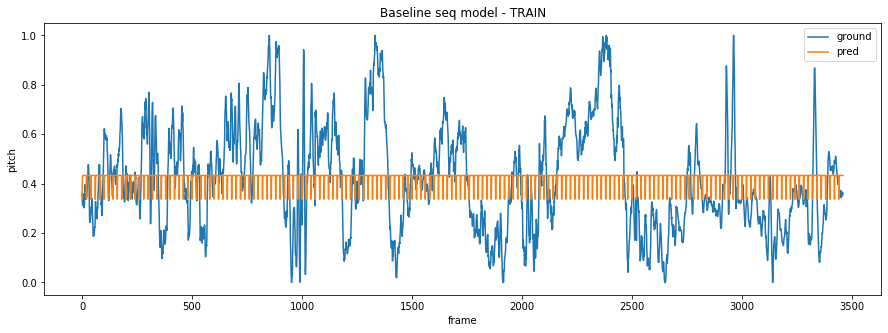

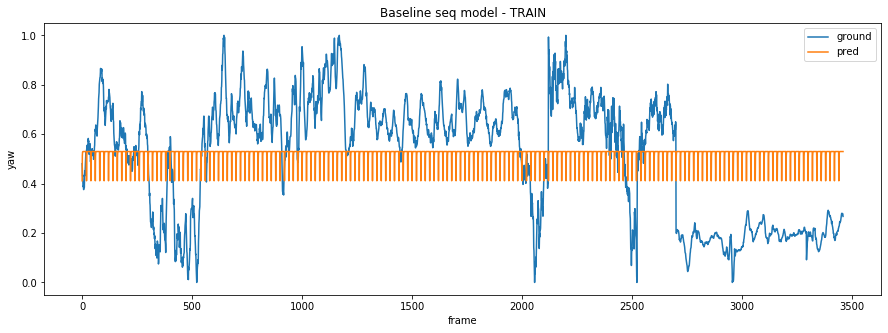

In [137]:
visualise_res_seqs(baseline_conv2d_lstm, train_gen_no_overlap, "frame", targets, "Baseline seq model - TRAIN")

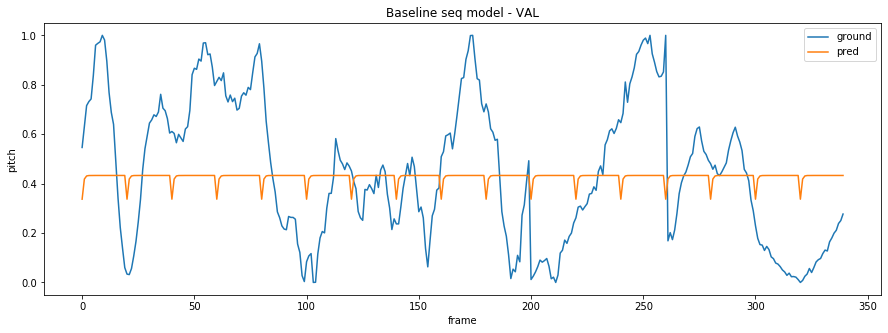

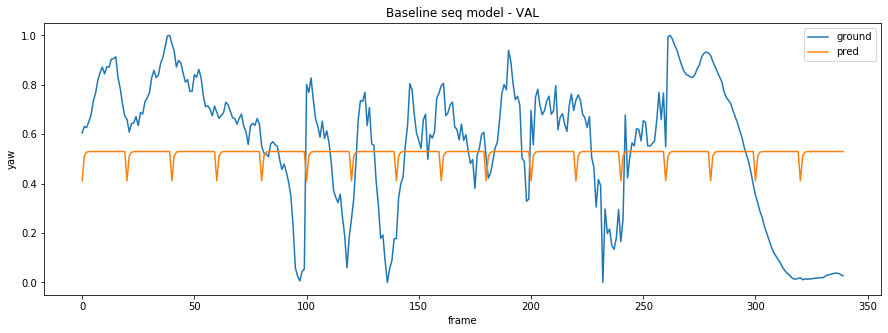

In [138]:
visualise_res_seqs(baseline_conv2d_lstm, val_gen_no_overlap, "frame", targets, "Baseline seq model - VAL")

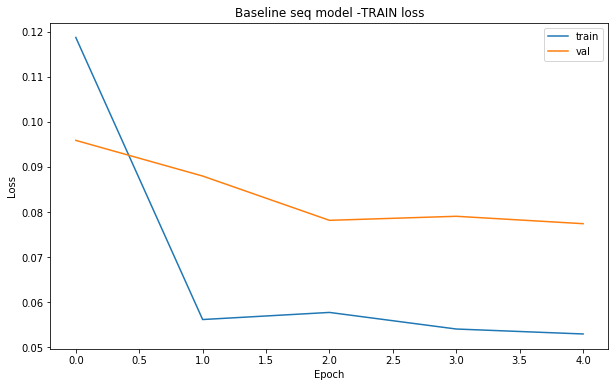

In [139]:
plot_res(baseline_conv2d_lstm_history, "Baseline seq model -TRAIN loss")

Something is seriously wrong. Why does every sequence have the same predictions?

- Are the labels messed up? - Checked, they seem fine.
- Is this the the average for all seqs? -> less epochs.
- Is the model "too weak"? - Probably!
- Is the overlap in the data too much? - Should not matter that much.
- Are the images broken? - Yes! But problem still persists after fix...
![broken_imgs](https://imgur.com/Fcd21k5.png)

- An error in the visualization? - Checked, all seems fine.

#### 6.3.2. Better encoder.

I will buff up the encoder, leaving the decoder much the same. This way the model will have more useful learning capacity.

In [140]:
tf.keras.backend.clear_session()

In [141]:
simple_conv2d_encoder = Sequential([
    Input(INPUT_DIMS),
    Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu"),
    Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu"),
    BatchNormalization(),
    MaxPool2D(),
    Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu"),
    Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu"),
    BatchNormalization(),
    MaxPool2D(),
    Conv2D(filters=256, kernel_size=(3, 3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3, 3), padding="same", activation="relu"),
    BatchNormalization(),
    MaxPool2D(),
    Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation="relu"),
    MaxPool2D(),
    BatchNormalization(),
    Flatten()
])

In [142]:
simple_conv2d_lstm = Sequential([
    Input(INPUT_DIMS_SEQ),
    TimeDistributed(simple_conv2d_encoder),
    LSTM(20, return_sequences=True),
    Dense(16, activation="relu"),
    Dense(2, activation=None)
])

In [143]:
simple_conv2d_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 20, 100352)        4689216   
_________________________________________________________________
lstm (LSTM)                  (None, 20, 20)            8029840   
_________________________________________________________________
dense (Dense)                (None, 20, 16)            336       
_________________________________________________________________
dense_1 (Dense)              (None, 20, 2)             34        
Total params: 12,719,426
Trainable params: 12,717,506
Non-trainable params: 1,920
_________________________________________________________________


In [144]:
simple_conv2d_lstm.compile(optimizer="adam", loss="mse", metrics=['mae'])

In [145]:
simple_conv2d_lstm_history = simple_conv2d_lstm.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5,
    callbacks=[
        tf.keras.callbacks.TensorBoard(log_dir="logs\logs_convLstmB",
                                       update_freq="batch")
    ])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 45 steps, validate for 4 steps
Epoch 1/5
45/45 [==============================] - 55s 1s/step - loss: 0.1201 - mae: 0.2584 - val_loss: 0.6249 - val_mae: 0.7211
Epoch 2/5
45/45 [==============================] - 52s 1s/step - loss: 0.0658 - mae: 0.2011 - val_loss: 0.5014 - val_mae: 0.5671
Epoch 3/5
45/45 [==============================] - 52s 1s/step - loss: 0.0626 - mae: 0.1995 - val_loss: 0.1979 - val_mae: 0.3274
Epoch 4/5
45/45 [==============================] - 51s 1s/step - loss: 0.0586 - mae: 0.1915 - val_loss: 0.1673 - val_mae: 0.3352
Epoch 5/5
45/45 [==============================] - 51s 1s/step - loss: 0.0558 - mae: 0.1803 - val_loss: 0.1321 - val_mae: 0.3013


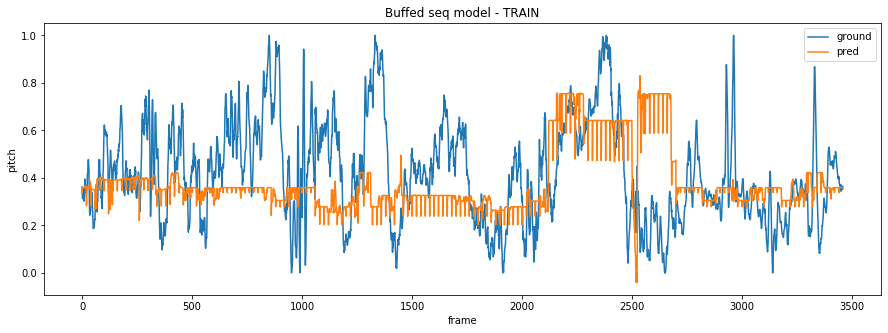

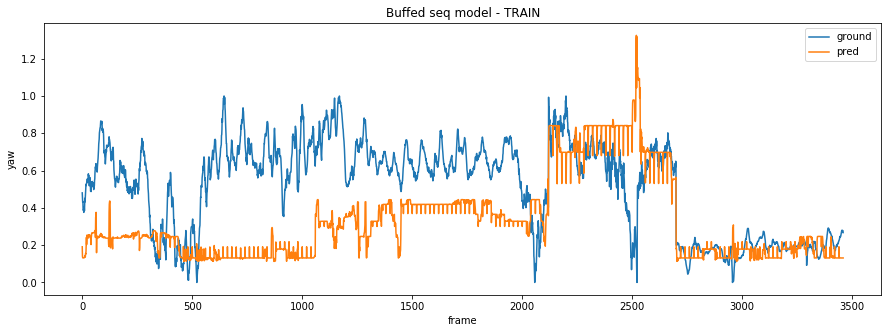

In [146]:
visualise_res_seqs(simple_conv2d_lstm, train_gen_no_overlap, "frame", targets, "Buffed seq model - TRAIN")

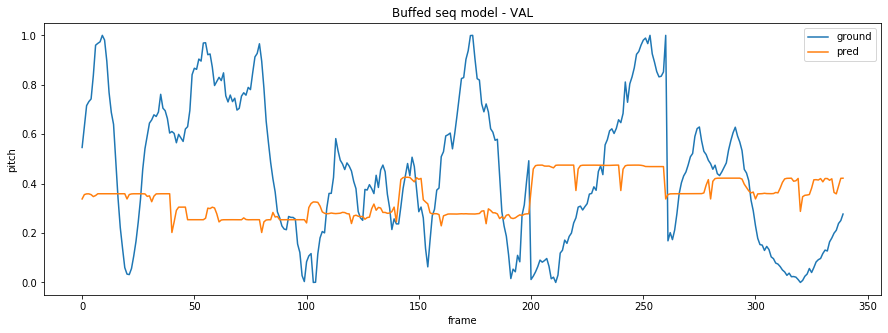

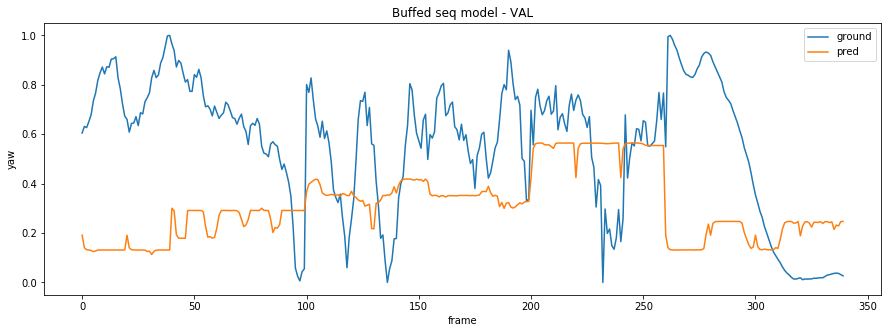

In [147]:
visualise_res_seqs(simple_conv2d_lstm, val_gen_no_overlap, "frame", targets, "Buffed seq model - VAL")

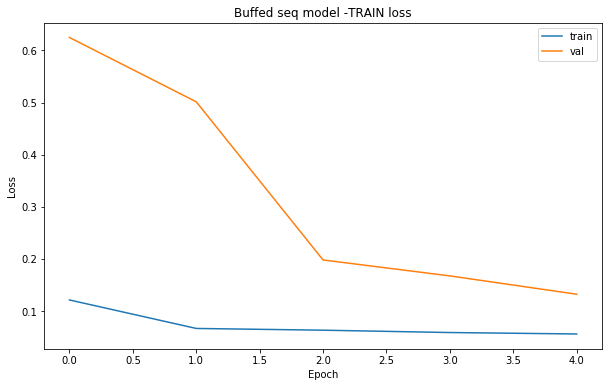

In [148]:
plot_res(simple_conv2d_lstm_history, "Buffed seq model -TRAIN loss")

This is worrisome. The strange periodicity still occurs, but whyy? And it is somehow improving. At this point I have little to no idea... Let's buff the decoder.

#### 6.3.3. Better decoder.

In [149]:
tf.keras.backend.clear_session()

In [150]:
simple_conv2d_lstm_better_encoder = Sequential([
    Input(INPUT_DIMS_SEQ),
    TimeDistributed(simple_conv2d_encoder),
    LSTM(40, return_sequences=True),
    LSTM(20, return_sequences=True),
    Dense(512, activation="relu"),
    Dense(128, activation="relu"),
    Dense(2, activation=None)
])

In [151]:
simple_conv2d_lstm_better_encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 20, 100352)        4689216   
_________________________________________________________________
lstm (LSTM)                  (None, 20, 40)            16062880  
_________________________________________________________________
lstm_1 (LSTM)                (None, 20, 20)            4880      
_________________________________________________________________
dense (Dense)                (None, 20, 512)           10752     
_________________________________________________________________
dense_1 (Dense)              (None, 20, 128)           65664     
_________________________________________________________________
dense_2 (Dense)              (None, 20, 2)             258       
Total params: 20,833,650
Trainable params: 20,831,730
Non-trainable params: 1,920
________________________________________

In [152]:
simple_conv2d_lstm_better_encoder.compile(optimizer=Adam(0.00001), loss="mse", metrics=['mae'])

In [153]:
simple_conv2d_lstm_better_encoder_history = simple_conv2d_lstm_better_encoder.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.TensorBoard(log_dir="logs\logs_conv_lstm_bed",
                                       update_freq="batch")
    ])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 45 steps, validate for 4 steps
Epoch 1/10
45/45 [==============================] - 55s 1s/step - loss: 0.1268 - mae: 0.3003 - val_loss: 0.1283 - val_mae: 0.3010
Epoch 2/10
45/45 [==============================] - 53s 1s/step - loss: 0.0724 - mae: 0.2226 - val_loss: 0.1049 - val_mae: 0.2697
Epoch 3/10
45/45 [==============================] - 52s 1s/step - loss: 0.0572 - mae: 0.1939 - val_loss: 0.0971 - val_mae: 0.2586
Epoch 4/10
45/45 [==============================] - 52s 1s/step - loss: 0.0492 - mae: 0.1729 - val_loss: 0.0931 - val_mae: 0.2542
Epoch 5/10
45/45 [==============================] - 52s 1s/step - loss: 0.0442 - mae: 0.1620 - val_loss: 0.0911 - val_mae: 0.2481
Epoch 6/10
45/45 [==============================] - 52s 1s/step - loss: 0.0398 - mae: 0.1497 - val_loss: 0.0917 - val_mae: 0.2491
Epoch 7/10
45/45 [==============================] - 52s 1s/step - loss: 0.0373 - mae: 0.1446 - val_loss: 0.0923 - val_mae: 0.2475

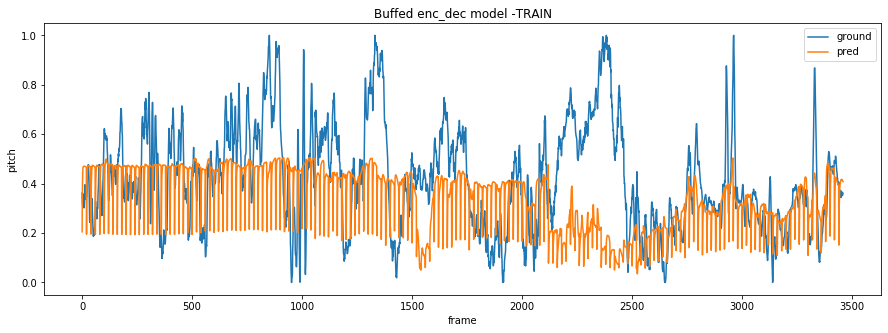

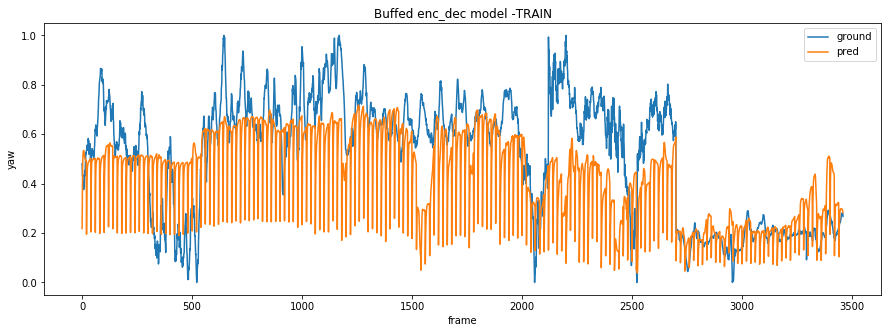

In [154]:
visualise_res_seqs(simple_conv2d_lstm_better_encoder, train_gen_no_overlap, "frame", targets, "Buffed enc_dec model -TRAIN")

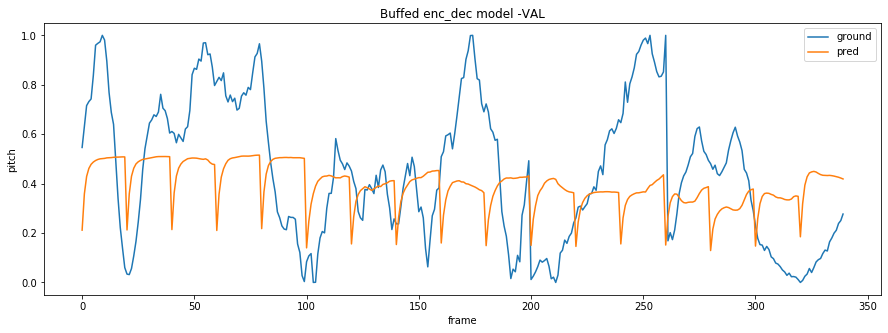

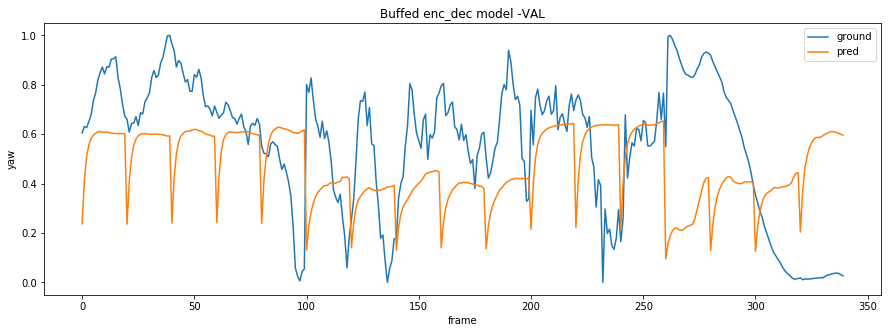

In [155]:
visualise_res_seqs(simple_conv2d_lstm_better_encoder, val_gen_no_overlap, "frame", targets, "Buffed enc_dec model -VAL")

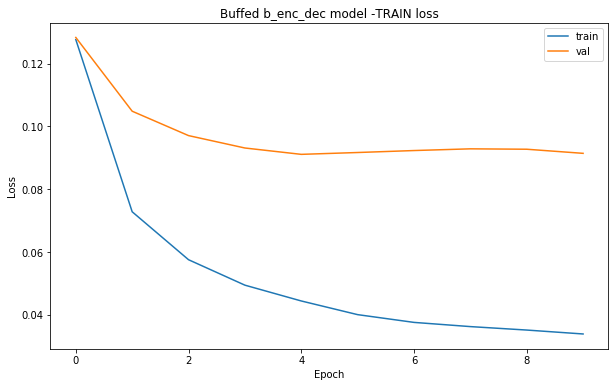

In [156]:
plot_res(simple_conv2d_lstm_better_encoder_history, "Buffed b_enc_dec model -TRAIN loss")

#### 6.3.4. Even better encoder, decoder combo with transfer learning.

In [158]:
tf.keras.backend.clear_session()

In [159]:
conv2d_lstm_resnet = Sequential([
    Input(INPUT_DIMS_SEQ),
    TimeDistributed(res_net_50V2),
    TimeDistributed(Flatten()),
    LSTM(64, return_sequences=True),
    Dense(128, activation="relu"),
    Dense(64, activation="relu"),
    Dense(16, activation="relu"),
    Dense(2, activation=None)
])

In [160]:
conv2d_lstm_resnet.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 20, 7, 7, 2048)    23564800  
_________________________________________________________________
time_distributed_1 (TimeDist (None, 20, 100352)        0         
_________________________________________________________________
lstm (LSTM)                  (None, 20, 64)            25706752  
_________________________________________________________________
dense (Dense)                (None, 20, 128)           8320      
_________________________________________________________________
dense_1 (Dense)              (None, 20, 64)            8256      
_________________________________________________________________
dense_2 (Dense)              (None, 20, 16)            1040      
_________________________________________________________________
dense_3 (Dense)              (None, 20, 2)             3

In [161]:
conv2d_lstm_resnet.compile(optimizer="adam", loss="mse", metrics=['mae'])

In [162]:
conv2d_lstm_resnet_history = conv2d_lstm_resnet.fit(train_gen,
                       validation_data=val_gen,
                       epochs=5,
                       callbacks=[
                           tf.keras.callbacks.TensorBoard(
                               log_dir="logs\logs_resnetLstm",
                               update_freq="batch")
                       ])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 45 steps, validate for 4 steps
Epoch 1/5
45/45 [==============================] - 58s 1s/step - loss: 0.0618 - mae: 0.2052 - val_loss: 0.0808 - val_mae: 0.2406
Epoch 2/5
45/45 [==============================] - 52s 1s/step - loss: 0.0559 - mae: 0.1974 - val_loss: 0.0918 - val_mae: 0.2588
Epoch 3/5
45/45 [==============================] - 52s 1s/step - loss: 0.0428 - mae: 0.1679 - val_loss: 0.1127 - val_mae: 0.2564
Epoch 4/5
45/45 [==============================] - 51s 1s/step - loss: 0.0451 - mae: 0.1714 - val_loss: 0.0922 - val_mae: 0.2527
Epoch 5/5
45/45 [==============================] - 51s 1s/step - loss: 0.0416 - mae: 0.1577 - val_loss: 0.0993 - val_mae: 0.2611


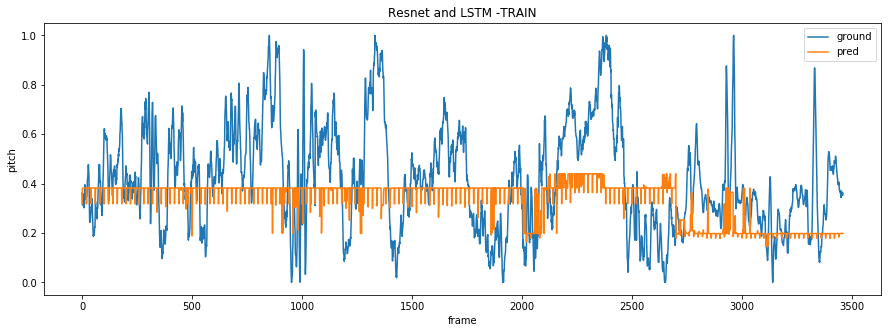

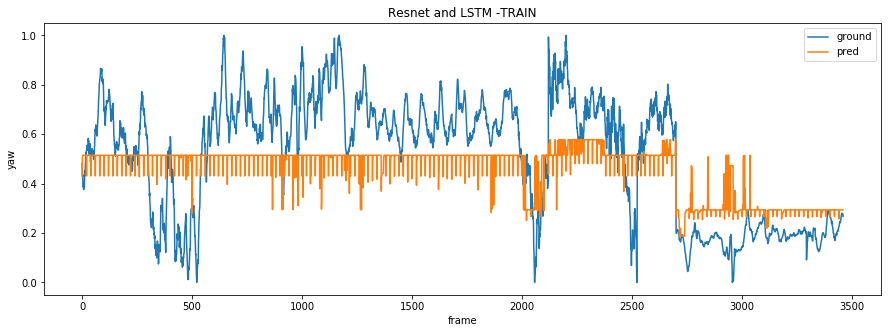

In [163]:
visualise_res_seqs(conv2d_lstm_resnet, train_gen_no_overlap, "frame", targets, "Resnet and LSTM -TRAIN")

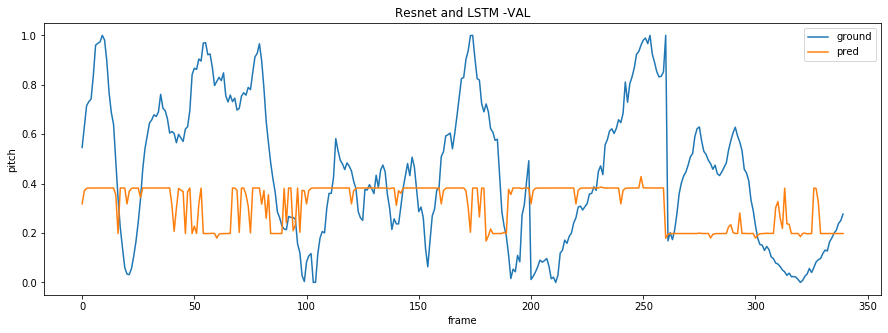

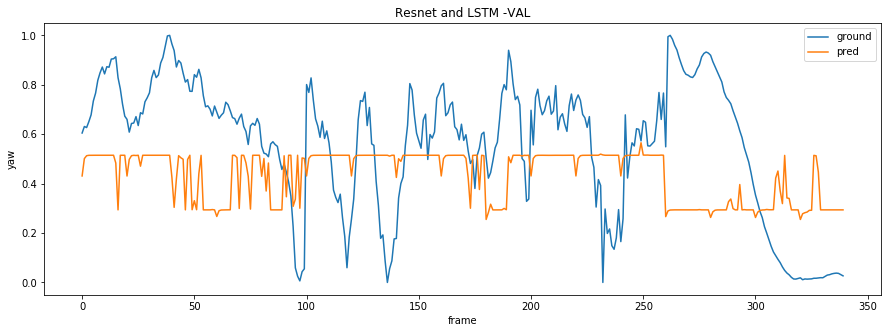

In [164]:
visualise_res_seqs(conv2d_lstm_resnet, val_gen_no_overlap, "frame", targets, "Resnet and LSTM -VAL")

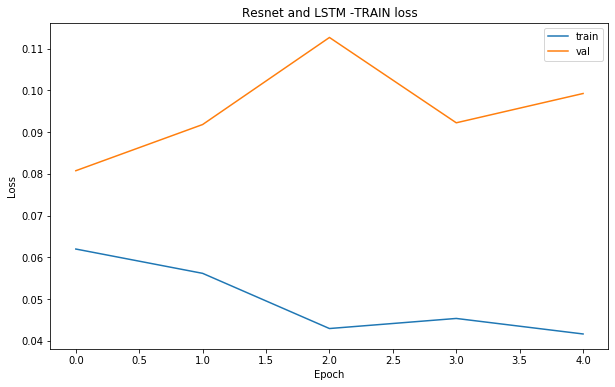

In [165]:
plot_res(conv2d_lstm_resnet_history, "Resnet and LSTM -TRAIN loss")

In [166]:
# Lesson learned, DO NOT go around errors, but
# understand them and troubleshoot!

### 6.4.1. Conv3D.

This part is not done. In an older version where I fed the model sequences of a couple frames, it worked on par with the other model. The problem here is that I have to modify my `DataGenerator` to that I have one average targets per 5-6 frames.

The premise of the model is not too complicated. 2D convolutional layers ahve 2d kernels, similarly, 3d conv layes have 3d kernels, which stride the "time block" and learn to "see" movement. The output is also a "time block".

![3d_convs](https://imgur.com/xS5iJsB.png)
[source](https://arxiv.org/abs/1412.0767?fbclid=IwAR1YAVjzhv8TeNXeHlsopWN7Jrm4ZRtJjoWYhrdo326VjbIV7w2rGPaKvxw)

In [167]:
tf.keras.backend.clear_session()

In [168]:
conv3d_baseline_model = Sequential([
    Input((20, 224, 224, 3)),
    Conv3D(64, (3, 3, 3), activation="relu", padding="same", data_format="channels_last"),
    MaxPool3D((1, 2, 2)),
    Conv3D(128, (3, 3, 3), activation="relu", padding="same", data_format="channels_last"),
    MaxPool3D(),
    Conv3D(256, (3, 3, 3), activation="relu", padding="same", data_format="channels_last"),
    Conv3D(256, (3, 3, 3), activation="relu", padding="same", data_format="channels_last"),
    MaxPool3D(),
    Conv3D(512, (3, 3, 3), activation="relu", padding="same", data_format="channels_last"),
    Conv3D(512, (3, 3, 3), activation="relu", padding="same", data_format="channels_last"),
    MaxPool3D(),
    Conv3D(512, (3, 3, 3), activation="relu", padding="same", data_format="channels_last"),
    Conv3D(512, (3, 3, 3), activation="relu", padding="same", data_format="channels_last"),
    MaxPool3D(),
    Dense(4096, activation="relu"),
    Dense(2048, activation="relu"),
    Flatten(),
    Dense(2, activation=None),
])

In [169]:
conv3d_baseline_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 20, 224, 224, 64)  5248      
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 20, 112, 112, 64)  0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 20, 112, 112, 128) 221312    
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 10, 56, 56, 128)   0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 10, 56, 56, 256)   884992    
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 10, 56, 56, 256)   1769728   
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 5, 28, 28, 256)    0

In [170]:
conv3d_baseline_model.compile(optimizer=Adam(), loss="mse", metrics=["mae"])

In [ ]:
conv3d_baseline_model.fit(train_gen,
                          validation_data=val_gen,
                          epochs=5,
                          callbacks=[
                              tf.keras.callbacks.TensorBoard(
                                  log_dir="logs\logs_conv3d",
                                  update_freq="batch")
                          ])

### 7. Previous work.

It was hard for me to find code on this particular challenge. There are plenty of cool examples for comma's previous challenge. Both are similar, looking at code examples from them helped immensely. [here](https://github.com/ryanchesler/comma-speed-challenge)

### 8. Future work.

1. Conv3D.
2. Yolo transfer learning.
3. Interpretability.
4. Additianal data generation (jitter, rotation).
5. VERSION CONTROL!
6. Learning not to start coding immediately.
7. Time management.
8. Fixing bugs, not working around them.

### 9. Closure on the project.

So all in all, I really needed to recalibrate my brain. There were many instances where I would literally stare at the screen for hours not knowing what to do next. Some days it was too scary to sit down and do some work, because I was sick of researching various errors. I feel more confident now, learned a lot, and motivated for more! Thank you for reading 😊.

### 10. Referances:

Methods used:

* Kingma, D. P. & Ba, J. (2014). Adam: A Method for Stochastic Optimization (cite arxiv:1412.6980Comment: Published as a conference paper at the 3rd International Conference for Learning Representations, San Diego, 2015)
* He, Kaiming, Xiangyu Zhang, Shaoqing Ren, and Jian Sun. "Deep residual learning for image recognition." In Proceedings of the IEEE conference on computer vision and pattern recognition, pp. 770-778. 2016.
* LeCun, Y., Bengio, Y. and Hinton, G., 2015. Deep learning. Nature, 521(7553), pp.436-444.
* Hochreiter, S., & Schmidhuber, J"urgen. (1997). Long short-term memory. Neural Computation, 9(8), 1735–1780.

Papers:

- [Learning Spatiotemporal Features with 3D Convolutional Networks](https://arxiv.org/abs/1412.0767?fbclid=IwAR1YAVjzhv8TeNXeHlsopWN7Jrm4ZRtJjoWYhrdo326VjbIV7w2rGPaKvxw)
- [Ridiculously Fast Shot Boundary Detection with Fully Convolutional Neural Networks](https://arxiv.org/abs/1705.08214?fbclid=IwAR2KiBCKcLzm9hYtG1fpinGKzQPQPn-MY7L_xqajJWE8l4Fofo8Di6THsdE)
- [Fast R-CNN](https://arxiv.org/abs/1504.08083)
- [Simple Online and Realtime Tracking](https://arxiv.org/abs/1602.00763v2)

Useful links:
- [A simple Conv3D example with TensorFlow 2 and Keras](https://www.machinecurve.com/index.php/2019/10/18/a-simple-conv3d-example-with-keras/)
- [Next-frame prediction with Conv-LSTM](https://keras.io/examples/vision/conv_lstm/)
- [Chan\`s Jupyter blog: RNN - Many-to-many](https://goodboychan.github.io/chans_jupyter/python/deep_learning/tensorflow-keras/2020/12/09/01-RNN-Many-to-many.html)
- [Stanford blog - RNN cheatsheet](https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-recurrent-neural-networks)
- [Python: Real-time Multiple Object Tracking (MOT) with Yolov3, Tensorflow and Deep SORT](https://www.youtube.com/watch?v=zi-62z-3c4U&ab_channel=eMasterClassAcademy)
- [Same predictions problem](https://stats.stackexchange.com/questions/261704/training-a-neural-network-for-regression-always-predicts-the-mean)
- [An Intuitive Explanation of Connectionist Temporal Classification](https://towardsdatascience.com/intuitively-understanding-connectionist-temporal-classification-3797e43a86c)
- [How to work with Time Distributed data in a neural network](https://medium.com/smileinnovation/training-neural-network-with-image-sequence-an-example-with-video-as-input-c3407f7a0b0f)
- [Training a neural network with an image sequence](https://medium.com/smileinnovation/training-neural-network-with-image-sequence-an-example-with-video-as-input-c3407f7a0b0f)
- [Comma.ai speed challange write-up](https://github.com/ryanchesler/comma-speed-challenge)
- [5 Regression Loss Functions All Machine Learners Should Know](https://heartbeat.fritz.ai/5-regression-loss-functions-all-machine-learners-should-know-4fb140e9d4b0)
- And more...

## Failed attempt at an end-to-end tensorflow data pipeline.
### What went wrong:
All was going fine until, I realized that the original frame order could not be kept. ` tf.data.Dataset.list_files(shuffle = Flase) ` returns the paths in a lexicographical order, where *frame10* is not after *frame9*. This is a huge problem since the data is time dependent. I tried sorting the dataset in step **5**, but it threw a strange error to which I could not find a solution. According to [this](https://stackoverflow.com/questions/46990088/tensorflow-dataset-api-how-to-order-list-files) post from "stackoverflow" it may not be possible at all. I learned a lot by attempting to make this pipeline, of course the tensorflow documentation was invaluable.

‎

1. Point to the folder containing the frames for each video.

```python
video_frames_root = pathlib.Path(DIR_VIDEO_FRAMES)
```
2. Get all img file paths.

```python
frame_paths = tf.data.Dataset.list_files(str(video_frames_root/"*/*"), shuffle = False)
```

3. Extract the video name and frame number from the path string returning (path, video_id, frame_number).

```python
def process_path(path):
    """
    Example input: b'data\\video_frames_labeled\\0\\frame1007.jpg'
    
    Output: path = b'data\\video_frames_labeled\\0\\frame1007.jpg'
            vid_id = 0.0
            frame_number = 1007.0
    """
    
    vid_id = tf.strings.split(path, os.sep)[-2]
    frame_name_with_extension = tf.strings.split(path, os.sep)[-1]
    frame_name = tf.strings.split(frame_name_with_extension, ".")[0]
    frame_number = tf.strings.split(frame_name, "frame")[-1]
    
    vid_id = tf.strings.to_number(vid_id, tf.float32)
    frame_number = tf.strings.to_number(frame_number, tf.float32)
    
    return (path, vid_id, frame_number)


frame_metadata = frame_paths.map(process_path)
```

4. Read the images, resize and normalize.

```python
def read_img(path, vid_id, frame_number):
    file = tf.io.read_file(path)
    img = tf.image.decode_jpeg(file, channels = 3)
    img = tf.image.resize(img, IMG_SIZE)
    img = img / 255.0
    return (img, vid_id, frame_number)


frame_data = frame_metadata.map(read_img)
```

5. Sort the frames by video name and frame number.

```python
frame_data_sorted = tf.sort(frame_data)
```

<div class="alert alert-block alert-danger">
    
<b>ValueError:</b> Attempt to convert a value (<MapDataset shapes: ((224, 224, 3), (), ()), types: (tf.float32, tf.float32, tf.float32)>) with an unsupported type (<class 'tensorflow.python.data.ops.dataset_ops.MapDataset'>) to a Tensor.

</div>

6. Point to the folder containing the labels.

```python
labels_root = pathlib.Path(DIR_LABELED)
```

7. Get the path to each ".txt" file.

```python
labels_paths = tf.data.Dataset.list_files(str(labels_root/"*.txt"), shuffle = False)
```

8. Read the lines.

```python
labels_data = tf.data.TextLineDataset(labels_paths)
```

9. Separate the two values (pitch and yaw) and convert to "np.float64".

```python
def sep_values(line):
    separated_values = tf.strings.split(line, " ")
    separated_values_float = tf.strings.to_number(separated_values, tf.float64)
    return separated_values_float

separated_labels_data = labels_data.map(sep_values)
```

10. Combine frame paths and labels

```python
frame_data = tf.data.Dataset.zip((frame_paths, separated_labels_data))
```

11. Remove NANs.

$ ‎‎‎‎‎‎‎‎‎‎‎‎‎‎‎‎‎‎‎‎‎‎\vdots $

12. Split the frame sequences of the original 5 videos into shorter sequnces. There should not be sequences that include scenes from 2 different videos.

$ ‎‎‎‎‎‎‎‎‎‎‎‎‎‎‎‎‎‎‎‎‎‎\vdots $